In [1]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [99]:
from torch.utils.cpp_extension import load
lltm_cuda = load(
    'lltm_cuda', ['neighSearch_cuda.cpp', 'neighSearch_cuda.cu'], verbose=True)
help(lltm_cuda)

Using /home/winchenbach/.cache/torch_extensions/py39_cu116 as PyTorch extensions root...
The input conditions for extension module lltm_cuda have changed. Bumping to version 1 and re-building as lltm_cuda_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/winchenbach/.cache/torch_extensions/py39_cu116/lltm_cuda/build.ninja...
Building extension module lltm_cuda_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] c++ -MMD -MF neighSearch_cuda.o.d -DTORCH_EXTENSION_NAME=lltm_cuda_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/include -isystem /home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/include/torch/csrc/api/include -isystem /home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/si

[2/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=lltm_cuda_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/include -isystem /home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/include/torch/csrc/api/include -isystem /home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/include/TH -isystem /home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/winchenbach/anaconda3/envs/torch_env/include/python3.9 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -std=c

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO:

1. ~~spherical emission~~
2. adaptive timestepping
3. ~~divergence solver~~
4. ~~xsph viscosity~~
5. monaghan viscosity
6. ~~setup dambreak~~
7. setup dambreak with obstacle
8. setup flow past cylinder
9. add wcsph (müller)
10. add compressible sph
11. setup shockwave scenario for compressible sph
12. ~~density solver warm start~~
13. ~~particle shifting~~
14. shifting needs thresholding for free surfaces!! (delta+ sph paper shifting idea based on renormalization vector??)
15. ~~velocityBC~~
16. device integrals for sdf based renormalization matrix
17. ~~rewrite MLS interpolation for stability based on delta+ sph~~
18. improve MLS performance
19. improve overall performance

In [3]:
import tomli

In [4]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-4
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = true
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBC]
periodicX = true
periodicY = true
buffer = 2

[velocitySources]
[velocitySources.one]
min = [-2,-2]
max = [-1,2]
velocity = [0,1]

[emitter]
[emitter.fluidCenter]
fillDomain = false
min = [-1, -1]
max = [ 1,  1]
velocity = [ 0.0, 0.0]

[emitters]
[emitters.fluidLeft]
fillDomain = false
min = [-1.75,-0.5]
max = [-0.75, 0.5]
velocity = [ 1.0, 0.0]
shape = 'sphere'
[emitters.fluidRight]
fillDomain = false
min = [ 0.75,-0.5]
max = [ 1.75, 0.5]
velocity = [-1.0, 0.0]
"""



In [5]:
from src.kernels import kernel, kernelGradient, wendland, wendlandGrad, cohesionKernel, getKernelFunctions

In [6]:
# @torch.jit.script
# def wendland(q, support):
#     C = 7 / np.pi
# #     print(q)
    
#     b1 = torch.pow(1. - q, 4)
# #     print(b1)
#     b2 = 1.0 + 4.0 * q
# #     print(b2)
#     return b1 * b2 * C / support**2    
# @torch.jit.script
# def wendlandGrad(q,r,support):
#     C = 7 / np.pi
    
#     return - r * C / support**3 * (20. * q * (1. -q)**3)[:,None]
   
    
# def getKernelFunctions(kernel):
#     if kernel == 'wendland2':
#         return wendland, wendlandGrad

In [7]:

from scipy.optimize import minimize

def genParticlesCentered(minCoord, maxCoord, radius, support, packing, dtype = torch.float32, device = 'cpu'):
    area = np.pi * radius**2
    
    gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    diff = maxCoord - minCoord
    center = (minCoord + maxCoord) / 2
    requiredSlices = torch.div(torch.ceil(diff / packing / support).type(torch.int64), 2, rounding_mode='floor')
    
    generatedParticles = []
#     print(requiredSlices)
    for i in range(-requiredSlices[0]-1, requiredSlices[0]+2):
        for j in range(-requiredSlices[1]-1, requiredSlices[1]+2):
            p = center
            g = gen_position(packing * support,i,j)
            pos = p + g
            if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2 and \
             pos[0] >= minCoord[0] - support * 0.2 and pos[1] >= minCoord[1] - support * 0.2:
                generatedParticles.append(pos)
                
    return torch.stack(generatedParticles)

def genParticles(minCoord, maxCoord, radius, packing, support, dtype, device):
    with record_function('config - gen particles'):
        area = np.pi * radius**2
#         support = np.sqrt(area * config['targetNeighbors'] / np.pi)
        
        gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    #     packing *= support
        
        diff = maxCoord - minCoord
        requiredSlices = torch.ceil(diff / packing / support).type(torch.int64)
        
    #     print(requiredSlices)
        generatedParticles = []
        for i in range(requiredSlices[0]+1):
            for j in range(requiredSlices[1]+1):
                p = minCoord
                g = gen_position(packing * support,i,j)
                pos = p + g
                if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2:
                    generatedParticles.append(pos)
        particles = torch.stack(generatedParticles)

        return particles


In [8]:

from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

In [9]:
# from src.solidBC import *

In [10]:
from src.module import Module
from src.parameter import Parameter

In [11]:
import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
#     for i in range(1024):
#         densityFn(fluidRadialDistances, fluidArea, fluidNeighbors, support)
#     for i in range(1024):
#         densityFn2(fluidRadialDistances, spreadAreas, fluidNeighbors, support)
#     for i in range(1024):
#         densityFn3(kernelProducts, spreadAreas, fluidNeighbors, support)
#     for i in range(1024):
#         sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)
        
        

In [12]:
class neighborSearchModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
        
    def getParameters(self):
        return [
            Parameter('neighborSearch', 'gradientThreshold', 'float', 1e-7, required = False, export = True, hint = '')
        ]
        
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.maxNeighbors = simulationConfig['compute']['maxNeighbors']
        self.threshold = simulationConfig['neighborSearch']['gradientThreshold']
        
    def search(self, simulationState, simulation):
        with record_function("sph - neighborhood"): 
            row, col = radius(simulationState['fluidPosition'], simulationState['fluidPosition'], self.support, max_num_neighbors = self.maxNeighbors)
            fluidNeighbors = torch.stack([row, col], dim = 0)

            fluidDistances = (simulationState['fluidPosition'][fluidNeighbors[1]] - simulationState['fluidPosition'][fluidNeighbors[0]])
            fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

            fluidDistances[fluidRadialDistances < self.threshold,:] = 0
            fluidDistances[fluidRadialDistances >= self.threshold,:] /= fluidRadialDistances[fluidRadialDistances >= self.threshold,None]
            fluidRadialDistances /= self.support

            return fluidNeighbors, fluidDistances, fluidRadialDistances


In [13]:
def neighborSearch(queryPositions, referencePositions, support, maxNeighbors, gradThreshold):
    with record_function("sph - neighborhood 2"): 
        row, col = radius(referencePositions, queryPositions, support, max_num_neighbors = maxNeighbors)
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (referencePositions[fluidNeighbors[1]] - queryPositions[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

        fluidDistances[fluidRadialDistances < gradThreshold,:] = 0
        fluidDistances[fluidRadialDistances >= gradThreshold,:] /= fluidRadialDistances[fluidRadialDistances >= gradThreshold,None]
        fluidRadialDistances /= support

        return fluidNeighbors, fluidDistances, fluidRadialDistances
@torch.jit.script
def jneighborSearch(queryPositions, referencePositions, support, maxNeighbors, gradThreshold):
    with record_function("sph - neighborhood 3"): 
        res = radius(referencePositions, queryPositions, support, max_num_neighbors = maxNeighbors)
        row = res[0]
        col = res[1]
#         print(res)
#         return None, None, None
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (referencePositions[fluidNeighbors[1]] - queryPositions[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,dim=-1)

        fluidDistances[fluidRadialDistances < gradThreshold,:] = 0
        fluidDistances[fluidRadialDistances >= gradThreshold,:] /= fluidRadialDistances[fluidRadialDistances >= gradThreshold,None]
        fluidRadialDistances /= support

        return fluidNeighbors, fluidDistances, fluidRadialDistances


In [40]:
simulationState = sphSimulation.simulationState

mod = neighborSearchModule()
mod.initialize(sphSimulation.config, sphSimulation)

queryPositions = simulationState['fluidPosition']
support = mod.support
gradientThreshold = mod.threshold
maxNeighbors = mod.maxNeighbors

supports = simulationState['fluidSupport']

In [41]:

hMax = torch.max(supports)
qMin = torch.min(queryPositions,dim=0)[0] - hMax
qMax = torch.max(queryPositions,dim=0)[0] + 2 * hMax

debugPrint(qMin)
debugPrint(qMax)

qEx = qMax - qMin
debugPrint(qEx / hMax)

cells = torch.ceil(qEx / hMax).to(torch.int64)
debugPrint(cells)

indices = torch.ceil((queryPositions - qMin) / hMax).to(torch.int64)
debugPrint(indices)
debugPrint(indices.shape)

particleIndices = torch.arange(queryPositions.shape[0], device = indices.device)
linearIndices = indices[:,0] + cells[0] * indices[:,1]


sort = torch.argsort(linearIndices)

debugPrint(particleIndices)
debugPrint(linearIndices)
debugPrint(sort)

debugPrint(particleIndices)
debugPrint(torch.any(particleIndices - particleIndices[sort] > 0))
sortedIndices = linearIndices[sort]
sortedPositions = queryPositions[sort,:]

debugPrint(particleIndices)

qMin [Tensor] = tensor([-2.0427, -2.0427])
qMax [Tensor] = tensor([-0.8989,  1.1050])
qEx / hMax [Tensor] = tensor([17.7640, 48.8876])
cells [Tensor] = tensor([18, 49])
indices [Tensor] = tensor([[ 2,  1],
        [ 2,  2],
        [ 2,  2],
        ...,
        [16, 47],
        [16, 47],
        [16, 47]])
indices.shape [Size] = torch.Size([4408, 2])
particleIndices [Tensor] = tensor([   0,    1,    2,  ..., 4405, 4406, 4407])
linearIndices [Tensor] = tensor([ 20,  38,  38,  ..., 862, 862, 862])
sort [Tensor] = tensor([   0,    1,  116,  ..., 4405, 4406, 4407])
particleIndices [Tensor] = tensor([   0,    1,    2,  ..., 4405, 4406, 4407])
torch.any(particleIndices - particleIndices[sort] > 0) [Tensor] = True
particleIndices [Tensor] = tensor([   0,    1,    2,  ..., 4405, 4406, 4407])


In [42]:
debugPrint(sortedIndices.shape)

sortedIndices.shape [Size] = torch.Size([4408])


In [43]:
linearIndices[-1]

tensor(862)

In [44]:
scanned = torch.hstack((torch.tensor([0], device = cells.device, dtype=linearIndices.dtype), sortedIndices))
scanned = scanned[1:] - scanned[:-1]
scanned = torch.clamp(scanned, -1, 1)
debugPrint(scanned)
debugPrint(sortedIndices)

scanned [Tensor] = tensor([1, 1, 0,  ..., 0, 0, 0])
sortedIndices [Tensor] = tensor([ 20,  38,  38,  ..., 862, 862, 862])


In [45]:
cellIndices, cellInverse, cellCounters = torch.unique_consecutive(sortedIndices, return_counts=True, return_inverse=True)
cumCell = torch.hstack((torch.tensor([0], device = cells.device, dtype=linearIndices.dtype),torch.cumsum(cellCounters,dim=0)))
scanned = torch.cumsum(cellCounters, dim = 0)
# debugPrint(cells)
# debugPrint(cellCounters)
# debugPrint(cellInverse)
# debugPrint(scanned)

hashMapLength = 4096


xIndices = cellIndices % cells[0]
yIndices = torch.div(cellIndices, cells[0], rounding_mode='trunc')
hashedIndices = (xIndices * 1212047 + yIndices * 15233249) % hashMapLength
hashCounters = torch.arange(hashedIndices.shape[0], device = hashedIndices.device)


hashIndexSorting = torch.argsort(hashedIndices)
# debugPrint(hashIndexSorting)

# debugPrint(xIndices)
# debugPrint(yIndices)
# debugPrint(hashedIndices[hashIndexSorting])
# debugPrint(hashCounters[hashIndexSorting])

hashMap, hashMapInverse, hashMapCounters = torch.unique_consecutive(hashedIndices[hashIndexSorting], return_counts=True, return_inverse=True)

debugPrint(hashMap)
debugPrint(hashMapCounters)
debugPrint(hashMapInverse)

hashTable = hashMap.new_ones(hashMapLength,2) * -1
hashTable[:,1] = 0
hashTable[hashMap,0] = torch.arange(hashMap.shape[0], device=hashMap.device)
hashTable[hashMap,1] = hashMapCounters

debugPrint(hashTable)

hashMap [Tensor] = tensor([   7,    8,    9,   18,   26,   36,   44,   53,   54,   55,   70,   71,
          72,   88,   89,   90,   99,  107,  116,  117,  118,  125,  134,  135,
         136,  151,  152,  153,  162,  169,  170,  171,  180,  188,  197,  198,
         199,  215,  216,  217,  232,  233,  234,  243,  251,  261,  269,  278,
         279,  280,  295,  296,  297,  306,  313,  314,  315,  324,  332,  341,
         342,  343,  350,  359,  360,  361,  376,  377,  378,  387,  395,  396,
         405,  413,  422,  423,  424,  440,  441,  442,  457,  458,  459,  468,
         476,  486,  487,  494,  503,  504,  505,  520,  521,  522,  538,  539,
         540,  549,  557,  566,  567,  568,  575,  584,  585,  586,  601,  602,
         603,  612,  620,  621,  630,  638,  647,  648,  649,  665,  666,  667,
         682,  683,  684,  693,  701,  711,  712,  719,  728,  729,  730,  745,
         746,  747,  764,  765,  774,  782,  791,  792,  793,  809,  810,  811,
         826,  827,  

In [46]:
cumHash = torch.hstack((torch.tensor([0], device = cells.device, dtype=linearIndices.dtype),torch.cumsum(hashMapCounters,dim=0)))

debugPrint(cumHash.dtype)
debugPrint(hashMapInverse.shape)

cumHash.dtype [dtype] = torch.int64
hashMapInverse.shape [Size] = torch.Size([692])


In [47]:
# debugPrint(cellIndex)
debugPrint(cellIndices)

cellIndices [Tensor] = tensor([ 20,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 200, 201, 202,
        203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 236,
        237, 238, 239, 240, 241, 242, 243

In [48]:
debugPrint(hashMap[469])

hashMap[469] [Tensor] = 2800


In [73]:


qP = torch.tensor([[-1.5, -1.5]], device = hashMap.device, dtype = queryPositions.dtype)
qID = torch.ceil((qP - qMin) / hMax).to(torch.int64)

@torch.jit.script
def queryHashMap(qLin, qHash, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort):
    hashEntries = hashTable[qHash]
    if hashEntries[0] == -1:
        return torch.empty(0,0, dtype = torch.int64, device = qLin.device)
    hashIndices = hashEntries[0]
    minIter = cumHash[hashIndices]
    maxIter = cumHash[hashIndices + 1]
    candidates = torch.empty(0,0, dtype = torch.int64, device = qLin.device)
#     return candidates
#     print(minIter.dtype)
    for i in range(int(minIter), int(maxIter)):
        hashIndex = hashIndexSorting[i]
        cellIndex = cellIndices[hashIndex]
        if cellIndex == qLin:
#             debugPrint(True)
            minCellIter = cumCell[hashIndex]
            maxCellIter = cumCell[hashIndex+1]        
            for j in range(int(minCellIter), int(maxCellIter)):
                candidates = sort[minCellIter:maxCellIter]
            break
    return candidates

@torch.jit.script
def linearFrom2D(qID, cells):
    return qID[0] + cells[0] * qID[1]
@torch.jit.script
def hashFrom2D(qID, hashMapLength):
    return (qID[0] * 1212047 + qID[1] * 15233249) % hashMapLength



# @torch.jit.script
def queryCellNeighborhood(qID, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort):
    qLin = linearFrom2D(qID, cells)
    qHash = hashFrom2D(qID, hashMapLength)

#     debugPrint(qID)
#     debugPrint(qLin)
#     debugPrint(qHash)

    neighborCells = []
    for i in range(-1,2):
        for j in range(-1,2):
            newID = qID + torch.tensor([i,j],device=qID.device, dtype=qID.dtype)
            c = queryHashMap(linearFrom2D(newID, cells), hashFrom2D(newID, hashMapLength), hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)
#             if
#             debugPrint(c)
            if c.shape[0] > 0:
                neighborCells.append(c)
    cN = torch.hstack(neighborCells)
#     debugPrint(cN)
#     debugPrint(cN.shape[0])
    cC = torch.ones_like(cN) * qLin
#     cC = torch.zeros(cN.shape, dtype = qID.dtype, device= qID.dtype)
#     cC = torch.empty(0,0, dtype = torch.int64, device = qLin.device)
#     cC[:] = qLin
    return torch.stack((cC, cN))
#     return queryHashMap(qLin, qHash)



@torch.jit.script
def buildCellNeighborhoods(indices, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort):
    uniqueIndices = torch.unique(indices,dim = 0)
    neighborhoods = []
#     i = 0
    for uid in uniqueIndices:
        neighborhoods.append(queryCellNeighborhood(uid, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort))
#         if ++i > 7: 
#             break
#     debugPrint(torch.hstack(neighborhoods))

#     debugPrint(neighborhoods)
    return torch.hstack(neighborhoods)

cellNeighbors = queryCellNeighborhood(qID[0], cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)

neighborLists = buildCellNeighborhoods(indices, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)

debugPrint(cellNeighbors)
debugPrint(neighborLists.shape)
debugPrint(neighborLists)

debugPrint(qP)

cellNeighbors [Tensor] = tensor([[ 171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,
          171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,
          171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,
          171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,
          171],
        [1989, 1873, 1872, 1988, 1875, 1874, 1876, 1990, 1992, 1991, 1878, 1994,
         1993, 1877, 2336, 2105, 2220, 2221, 2104, 2337, 2340, 2106, 2339, 2224,
         2223, 2338, 2108, 2107, 2222, 2341, 2342, 2110, 2109, 2226, 2225, 2568,
         2569, 2453, 2452, 2572, 2456, 2455, 2454, 2571, 2570, 2457, 2458, 2574,
         2573]])
neighborLists.shape [Size] = torch.Size([2, 37314])
neighborLists [Tensor] = tensor([[  55,   55,   55,  ...,  862,  862,  862],
        [   3,    1,  116,  ..., 4405, 4406, 4407]])
qP [Tensor] = tensor([[-1.5000, -1.5000]])


In [80]:

qP = torch.tensor([[-0.95, -1.5], [-1.5, -1.5]], device = hashMap.device, dtype = queryPositions.dtype)
qP = queryPositions

qID = torch.ceil((qP - qMin) / hMax).to(torch.int64)
debugPrint(qID)
qIDs = []
qLIDs = []
for i in range(-1,2):
    for j in range(-1,2):
        qIDs.append(qID + torch.tensor([i,j],device=qID.device, dtype=qID.dtype))
        qLIDs.append(linearFrom2Ds(qIDs[-1], cells))
qIDs = torch.vstack(qIDs)
qLIDs = torch.hstack(qLIDs)
# qIDs = torch.unique(qIDs,dim=0)
debugPrint(qIDs)
debugPrint(qLIDs)

qID [Tensor] = tensor([[ 2,  1],
        [ 2,  2],
        [ 2,  2],
        ...,
        [16, 47],
        [16, 47],
        [16, 47]])
qIDs [Tensor] = tensor([[ 1,  0],
        [ 1,  1],
        [ 1,  1],
        ...,
        [17, 48],
        [17, 48],
        [17, 48]])
qLIDs [Tensor] = tensor([  1,  19,  19,  ..., 881, 881, 881])


In [95]:


# connectivity = torch.zeros(cellIndices.shape[0],cellIndices.shape[0], dtype = torch.int64, layout = torch.sparse_coo, device = qP.device, requires_grad = False)

@torch.jit.script
def linearFrom2Ds(qID, cells):
    return qID[:,0] + cells[0] * qID[:,1]
@torch.jit.script
def hashFrom2Ds(qID, hashMapLength):
    return (qID[:,0] * 1212047 + qID[:,1] * 15233249) % hashMapLength

@torch.jit.script
def constructCellNeighborhoods(qLIDs, qIDs, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort):
#     debugPrint(cellIndices.shape[0])
#     debugPrint(cells)
    with record_function("index generation"): 
        qLins = linearFrom2Ds(qIDs, cells)
        qHashes = hashFrom2Ds(qIDs, hashMapLength)

#     debugPrint(qLins)
#     debugPrint(qHashes)


    with record_function("index filtering generation"): 
        hashEntries = hashTable[qHashes]
        filteredLinear = qLins[hashEntries[:,0] != -1]
        filteredEntries = hashEntries[hashEntries[:,0] != -1]
        filteredQLinear = qLIDs[hashEntries[:,0] != -1]

    with record_function("iter prep"): 
    #     debugPrint(filteredLinear)
    #     debugPrint(filteredEntries)

        hashIndices = filteredEntries[:,0]
        minIter = cumHash[hashIndices]
        maxIter = cumHash[hashIndices + 1]

        maxCount = torch.max(filteredEntries[:,1])
        # maxCount = 2

    #     debugPrint(minIter)
    #     debugPrint(maxIter)

        rows = []
        cols = []

    with record_function("loop"): 
        for i in range(int(maxCount)):
            with record_function("loop filtering"): 
                ii = minIter + i
                mask = ii < maxIter
                ii = ii[mask]
                flin = filteredLinear[mask]
                fqlin = filteredQLinear[mask]

    #         debugPrint(ii)
    #         debugPrint(flin)

        #     clamped = torch.clamp(minIter + i,minIter,maxIter)
        #     debugPrint(clamped)
            with record_function("loop iter generation"): 
                hashIndex = hashIndexSorting[ii]
        #         debugPrint(hashIndex)
                cellIndex = cellIndices[hashIndex]
        #         debugPrint(cellIndex)

                minCellIter = cumCell[hashIndex]
                maxCellIter = cumCell[hashIndex+1]

                minCellIter = minCellIter[cellIndex == flin]
                maxCellIter = maxCellIter[cellIndex == flin]
                flin = flin[cellIndex == flin]

    #         debugPrint(minCellIter)
    #         debugPrint(maxCellIter)

            with record_function("loop iter stacking"): 
                col = torch.hstack([torch.arange(s,e, dtype=torch.int64, device = minCellIter.device) for s, e in zip(minCellIter, maxCellIter)])
                row = torch.hstack([torch.ones(e-s, dtype=torch.int64, device = minCellIter.device) * f for s, e, f in zip(minCellIter, maxCellIter, fqlin)])
        #         debugPrint(col)
        #         debugPrint(row)

            with record_function("loop finalizing"): 
                rows.append(row)
                cols.append(col)
    return rows, cols
#     ranges = torch.arange(minCellIter, maxCellIter, dtype=torch.int64, device = minCellIter.device)
#     debugPrint(ranges)
    
#     debugPrint(sort[minCellIter[0]:maxCellIter[0]])
    
# debugPrint(hashIndex)

#     hashEntries = hashTable[qHash]
#     if hashEntries[0] == -1:
#         return torch.empty(0,0, dtype = torch.int64, device = qLin.device)
#     hashIndices = hashEntries[0]
#     minIter = cumHash[hashIndices]
#     maxIter = cumHash[hashIndices + 1]
#     candidates = torch.empty(0,0, dtype = torch.int64, device = qLin.device)
# #     return candidates
# #     print(minIter.dtype)
#     for i in range(int(minIter), int(maxIter)):
#         hashIndex = hashIndexSorting[i]
#         cellIndex = cellIndices[hashIndex]
#         if cellIndex == qLin:
# #             debugPrint(True)
#             minCellIter = cumCell[hashIndex]
#             maxCellIter = cumCell[hashIndex+1]        
#             for j in range(int(minCellIter), int(maxCellIter)):
#                 candidates = sort[minCellIter:maxCellIter]
#             break
#     return candidates
neighborLists = constructCellNeighborhoods(qLIDs, qIDs, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/tmp/ipykernel_402/2273997045.py", line 26, in constructCellNeighborhoods
        filteredLinear = qLins[hashEntries[:,0] != -1]
        filteredEntries = hashEntries[hashEntries[:,0] != -1]
        filteredQLinear = qLIDs[hashEntries[:,0] != -1]
                          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE

    with record_function("iter prep"): 
RuntimeError: The shape of the mask [822] at index 0 does not match the shape of the indexed tensor [39672] at index 0


In [76]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in range(1):
        neighborLists = buildCellNeighborhoods(indices, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)
#     for i in range(128):
#         neighs, distances, raddistances = neighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
#     for i in range(128):
#         neighs, distances, raddistances = jneighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
    
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

[W CPUAllocator.cpp:219] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
       buildCellNeighborhoods        34.05%     584.025ms       100.00%        1.715s        1.715s     583.02 Kb    -309.75 Kb             1  
                  aten::index        16.89%     289.803ms        24.18%     414.799ms      11.675us     186.00 Kb    -102.24 Kb         35528  
                   aten::item        10.73%     183.994ms        11.39%     195.446ms       2.232us     -78.58 Kb     -64.43 Kb         87560  
                 aten::select         8.31%     142.621ms         8.91%     152.922ms       2.906us           0 b           0 b         

In [93]:


# connectivity = torch.zeros(cellIndices.shape[0],cellIndices.shape[0], dtype = torch.int64, layout = torch.sparse_coo, device = qP.device, requires_grad = False)

@torch.jit.script
def linearFrom2Ds(qID, cells):
    return qID[:,0] + cells[0] * qID[:,1]
@torch.jit.script
def hashFrom2Ds(qID, hashMapLength):
    return (qID[:,0] * 1212047 + qID[:,1] * 15233249) % hashMapLength

@torch.jit.script
def constructCellNeighborhoods(qIDs, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort):
#     debugPrint(cellIndices.shape[0])
#     debugPrint(cells)
    qLins = linearFrom2Ds(qIDs, cells)
    qHashes = hashFrom2Ds(qIDs, hashMapLength)

#     debugPrint(qLins)
#     debugPrint(qHashes)


    hashEntries = hashTable[qHashes]
#     debugPrint(hashEntries)

    filteredLinear = qLins[hashEntries[:,0] != -1]
    filteredEntries = hashEntries[hashEntries[:,0] != -1]

#     debugPrint(filteredLinear)
#     debugPrint(filteredEntries)

    hashIndices = filteredEntries[:,0]
    minIter = cumHash[hashIndices]
    maxIter = cumHash[hashIndices + 1]

    maxCount = torch.max(filteredEntries[:,1])
    # maxCount = 2

#     debugPrint(minIter)
#     debugPrint(maxIter)

    rows = []
    cols = []

    for i in range(int(maxCount)):
        ii = minIter + i
        mask = ii < maxIter
        ii = ii[mask]
        flin = filteredLinear[mask]

#         debugPrint(ii)
#         debugPrint(flin)

    #     clamped = torch.clamp(minIter + i,minIter,maxIter)
    #     debugPrint(clamped)
        hashIndex = hashIndexSorting[ii]
#         debugPrint(hashIndex)
        cellIndex = cellIndices[hashIndex]
#         debugPrint(cellIndex)

        minCellIter = cumCell[hashIndex]
        maxCellIter = cumCell[hashIndex+1]

        minCellIter = minCellIter[cellIndex == flin]
        maxCellIter = maxCellIter[cellIndex == flin]
        flin = flin[cellIndex == flin]

#         debugPrint(minCellIter)
#         debugPrint(maxCellIter)

        col = torch.hstack([torch.arange(s,e, dtype=torch.int64, device = minCellIter.device) for s, e in zip(minCellIter, maxCellIter)])
        row = torch.hstack([torch.ones(e-s, dtype=torch.int64, device = minCellIter.device) * f for s, e, f in zip(minCellIter, maxCellIter, flin)])
#         debugPrint(col)
#         debugPrint(row)

        rows.append(row)
        cols.append(col)
    return rows, cols
#     ranges = torch.arange(minCellIter, maxCellIter, dtype=torch.int64, device = minCellIter.device)
#     debugPrint(ranges)
    
#     debugPrint(sort[minCellIter[0]:maxCellIter[0]])
    
# debugPrint(hashIndex)

#     hashEntries = hashTable[qHash]
#     if hashEntries[0] == -1:
#         return torch.empty(0,0, dtype = torch.int64, device = qLin.device)
#     hashIndices = hashEntries[0]
#     minIter = cumHash[hashIndices]
#     maxIter = cumHash[hashIndices + 1]
#     candidates = torch.empty(0,0, dtype = torch.int64, device = qLin.device)
# #     return candidates
# #     print(minIter.dtype)
#     for i in range(int(minIter), int(maxIter)):
#         hashIndex = hashIndexSorting[i]
#         cellIndex = cellIndices[hashIndex]
#         if cellIndex == qLin:
# #             debugPrint(True)
#             minCellIter = cumCell[hashIndex]
#             maxCellIter = cumCell[hashIndex+1]        
#             for j in range(int(minCellIter), int(maxCellIter)):
#                 candidates = sort[minCellIter:maxCellIter]
#             break
#     return candidates
neighborLists = constructCellNeighborhoods(qIDs, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)

In [94]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in range(1):
        qP = queryPositions

        qID = torch.ceil((qP - qMin) / hMax).to(torch.int64)
#         debugPrint(qID)
        qIDs = []
        for i in range(-1,2):
            for j in range(-1,2):
                qIDs.append(qID + torch.tensor([i,j],device=qID.device, dtype=qID.dtype))
        qIDs = torch.vstack(qIDs)
        qIDs = torch.unique(qIDs,dim=0)
        debugPrint(qIDs.shape)
        neighborLists = constructCellNeighborhoods(qIDs, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)
#     for i in range(128):
#         neighs, distances, raddistances = neighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
#     for i in range(128):
#         neighs, distances, raddistances = jneighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
    
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

qIDs.shape [Size] = torch.Size([822, 2])
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
              aten::unique_dim        30.27%     105.261ms        86.61%     301.157ms     301.157ms     632.72 Kb    -619.88 Kb             1  
                  aten::select        23.68%      82.331ms        33.17%     115.359ms       0.942us           0 b           0 b        122491  
                  aten::unbind         5.44%      18.900ms        16.63%      57.838ms      57.838ms           0 b           0 b             1  
    constructCellNeighborhoods         3.83%      13.313ms        13.17%      45.807ms   

In [96]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in range(1):
        qP = queryPositions

        qID = torch.ceil((qP - qMin) / hMax).to(torch.int64)
        qIDs = []
        qLIDs = []
        for i in range(-1,2):
            for j in range(-1,2):
                qIDs.append(qID + torch.tensor([i,j],device=qID.device, dtype=qID.dtype))
                qLIDs.append(linearFrom2Ds(qIDs[-1], cells))
        qIDs = torch.vstack(qIDs)
        qLIDs = torch.hstack(qLIDs)
        debugPrint(qIDs.shape)
        
        neighborLists = constructCellNeighborhoods(qLIDs, qIDs, cells, hashMapLength, hashTable, cumHash, hashIndexSorting, cellIndices, cumCell, sort)
#     for i in range(128):
#         neighs, distances, raddistances = neighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
#     for i in range(128):
#         neighs, distances, raddistances = jneighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
    
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

qIDs.shape [Size] = torch.Size([39672, 2])
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    constructCellNeighborhoods         0.00%      26.000us        99.96%        2.772s        2.772s       3.55 Mb          16 b             1  
                          loop        -0.00%     -44.000us        99.89%        2.771s        2.771s       2.41 Mb      -1.14 Mb             1  
            loop iter stacking        41.45%        1.150s        99.85%        2.769s        2.769s       2.70 Mb    -800.93 Kb             1  
                  aten::hstack         2.42%      67.019ms        15.90%     441.023ms 

In [122]:
uniqueIndices = torch.unique(indices,dim = 0)
debugPrint(indices)
debugPrint(uniqueIndices.shape)
debugPrint(cellIndices.shape)


indices [Tensor] = tensor([[ 2,  1],
        [ 2,  2],
        [ 2,  2],
        ...,
        [16, 47],
        [16, 47],
        [16, 47]], device='cuda:0')
uniqueIndices.shape [Size] = torch.Size([692, 2])
cellIndices.shape [Size] = torch.Size([692])


<IPython.core.display.Javascript object>


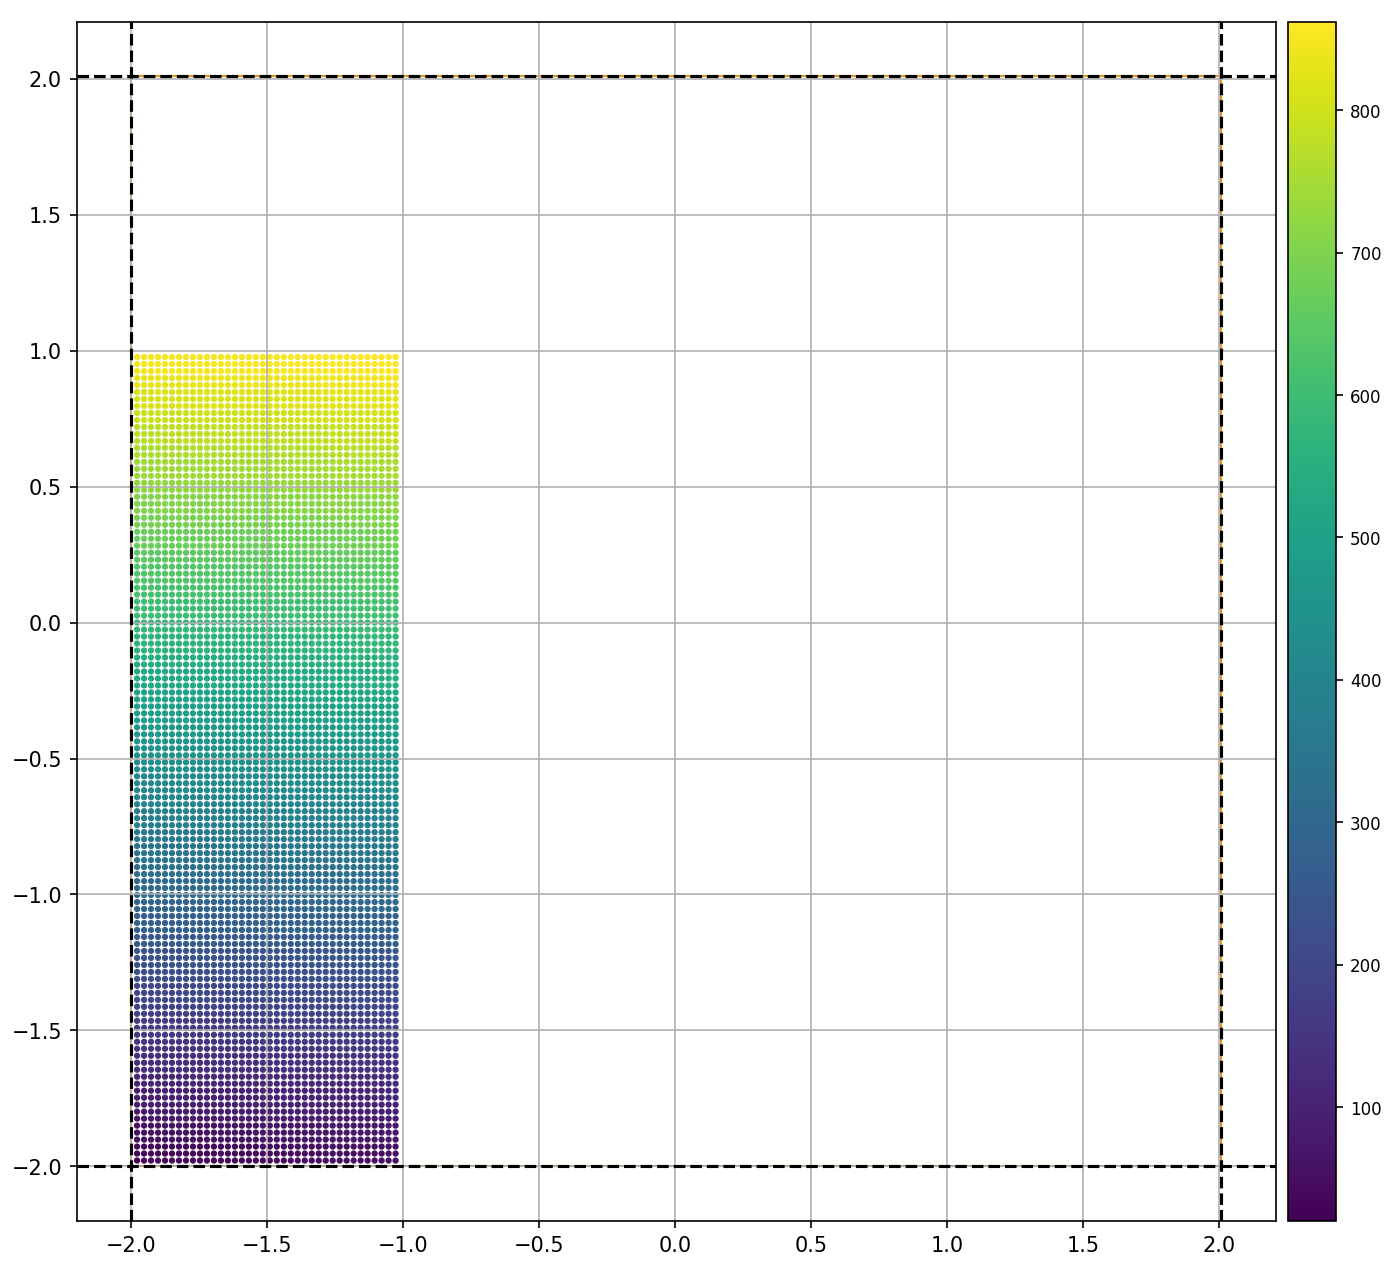

np.min(data) [int64] = 20
np.max(data) [int64] = 862


In [85]:

# fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
fig, axis = sphSimulation.createPlot(plotScale = 2)

# x = torch.linspace(0,1,127)

positions = sortedPositions.detach().cpu().numpy()
data = sortedIndices.detach().cpu().numpy()
debugPrint(np.min(data))
debugPrint(np.max(data))

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)

# # axis[0,0].axhline(0)
axis[0,0].grid(True)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
    
    
fig.tight_layout()

<IPython.core.display.Javascript object>


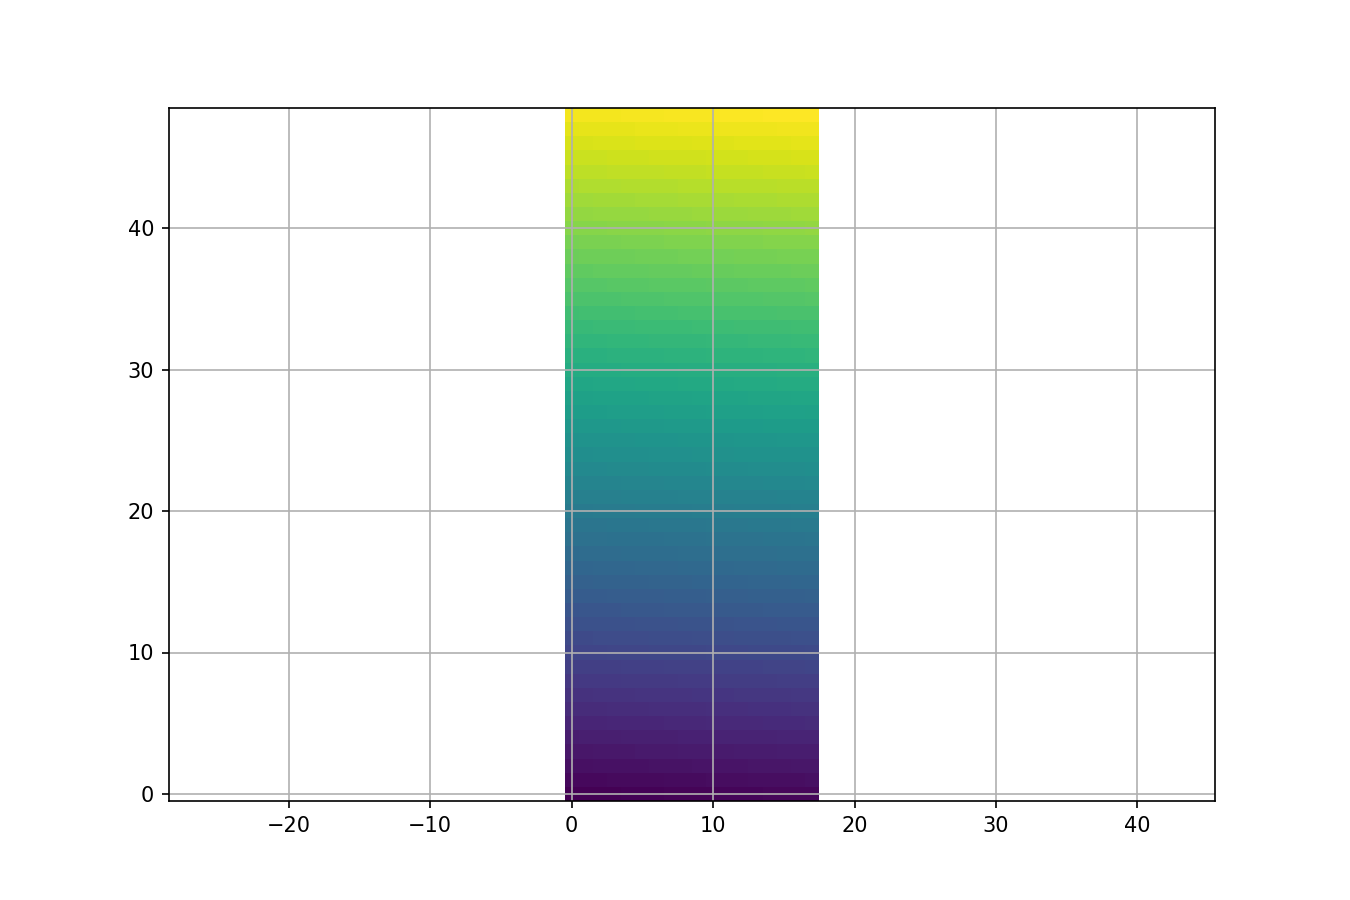

(-0.5, 17.5, -0.5, 48.5)

In [84]:
xIdx = torch.arange(cells[0])
yIdx = torch.arange(cells[1])
xx,yy = torch.meshgrid(xIdx, yIdx)

fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

# x = torch.linspace(0,1,127)
axis[0,0].pcolormesh(xx,yy,xx + cells[0].cpu() * yy)
# # axis[0,0].axhline(0)
axis[0,0].grid(True)
axis[0,0].axis('equal')

    

In [65]:



neighs, distances, raddistances = mod.search(sphSimulation.simulationState, sphSimulation)
neighs, distances, raddistances = neighborSearch(torch.tensor([[0,0]], device = queryPositions.device, dtype=queryPositions.dtype), queryPositions, support, maxNeighbors, gradientThreshold)
neighs, distances, raddistances = neighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
neighs, distances, raddistances = jneighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)

In [66]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in range(128):
        neighs, distances, raddistances = mod.search(sphSimulation.simulationState, sphSimulation)
    for i in range(128):
        neighs, distances, raddistances = neighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
    for i in range(128):
        neighs, distances, raddistances = jneighborSearch(queryPositions, queryPositions, support, maxNeighbors, gradientThreshold)
    
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          aten::nonzero        10.81%      96.356ms        48.93%     436.159ms     212.968us      35.980ms        10.28%      35.980ms      17.568us           0 b           0 b       1.24 Gb       2.02 M

In [13]:
# @torch.jit.script
# class Foo:
#   def __init__(self, x, y):
#     self.x = x

#   def aug_add_x(self, inc):
#     self.x += inc

In [14]:
# @torch.jit.script
# class wendland2Kernel:
#     def kernel(q,h):
#         C = 7 / np.pi
#         b1 = torch.pow(1. - q, 4)
#         b2 = 1.0 + 4.0 * q
#         return b1 * b2 * C / h**2    
    
#     def gradient(q,r,h):
#         C = 7 / np.pi    
#         return - r * C / h**3 * (20. * q * (1. -q)**3)[:,None]

In [15]:
from src.modules.density import densityModule
    

In [16]:
@torch.jit.script
def LinearCG(H, B, x0, i, j, tol=1e-5, verbose = False):    
    xk = x0
    rk = torch.zeros_like(x0)
    numParticles = rk.shape[0] // 2

    rk[::2]  += scatter(H[:,0,0] * xk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
    rk[::2]  += scatter(H[:,0,1] * xk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")

    rk[1::2] += scatter(H[:,1,0] * xk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
    rk[1::2] += scatter(H[:,1,1] * xk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")
    
    rk = rk - B
    
    pk = -rk
    rk_norm = torch.linalg.norm(rk)
    
    num_iter = 0

    if verbose:
        print('xk: ', x0)
        print('rk: ', rk)
        print('|rk|: ', rk_norm)
        print('pk: ', pk)


    while rk_norm > tol and num_iter < 32:
        apk = torch.zeros_like(x0)

        apk[::2]  += scatter(H[:,0,0] * pk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
        apk[::2]  += scatter(H[:,0,1] * pk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")

        apk[1::2] += scatter(H[:,1,0] * pk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
        apk[1::2] += scatter(H[:,1,1] * pk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")

        rkrk = torch.dot(rk, rk)
        
        alpha = rkrk / torch.dot(pk, apk)
        xk = xk + alpha * pk
        rk = rk + alpha * apk
        beta = torch.dot(rk, rk) / rkrk
        pk = -rk + beta * pk
        
        num_iter += 1

        rk_norm = torch.linalg.norm(rk)
        if verbose:
            print('iter: ', num_iter)
            print('\t|rk|: ', rk_norm)
            print('\talpha: ', alpha)
            
    return xk



In [17]:
@torch.jit.script
def x2c2(dInput, cr):
    zeroTensor = dInput.new_zeros(dInput.shape)
    dr = torch.abs(dInput)    
    dr[torch.abs(dr) < 1e-5] = 1
    
    d = torch.complex(dr, zeroTensor)
    c = torch.complex(cr, zeroTensor)
    
    a1 = ((-210*torch.cos(2*c)-75)*d**7+(-1260*torch.cos(2*c)-378)*d**5)*torch.log(torch.sqrt(1-d**2)+1)
    a2 = (75*d**7+378*d**5)*torch.log(torch.sqrt(1-d**2)-1)
    a3 = (210*torch.cos(2*c)*d**7+1260*torch.cos(2*c)*d**5)*torch.log(d)
    a4 = -24*torch.arccos(d)
    a5 = 0. #75.j*torch.arctan2(zeroTensor,torch.sqrt(1-dr**2)-1)*d**7
    a6 = torch.sqrt(1-d**2)*((1134*torch.cos(2*c)+746)*d**5+(392*torch.cos(2*c)+152)*d**3+(32-56*torch.cos(2*c))*d)
    a7 = 0. #378.j*torch.arctan2(zeroTensor,torch.sqrt(1-dr**2)-1)*d**5
    term = -(a1 + a2 + a3 + a4 + a5 + a6 + a7) /(24*np.pi)
    
    term[dInput < 0.] = 1 - term[dInput<0.]
    term[torch.abs(dInput) < 1e-5] = 1/2

    return term.real

@torch.jit.script
def x2cs(dInput, cr):
    dr = torch.abs(dInput)    
    dr[torch.abs(dr) < 1e-5] = 1
    
    d = dr + 0.j
    c = cr + 0.j
    
    a1 = (-105*torch.sin(2*c)*d**7-630*torch.sin(2*c)*d**5)*torch.log(torch.sqrt(1-d**2)+1)
    a2 = (105*torch.sin(2*c)*d**7+630*torch.sin(2*c)*d**5)*torch.log(d)
    a3 = torch.sqrt(1-d**2)*(567*torch.sin(2*c)*d**5+196*torch.sin(2*c)*d**3-28*torch.sin(2*c)*d)
    term = -(a1 + a2 + a3) /(12*np.pi)
    
    term[dInput < 0.] = 0 - term[dInput<0.]
    term[torch.abs(dInput) < 1e-5] = 0

    return term.real
@torch.jit.script
def x2s2(dInput, cr):
    zeroTensor = dInput.new_zeros(dInput.shape)
    dr = torch.abs(dInput)    
    dr[torch.abs(dr) < 1e-5] = 1
    
    d = dr + 0.j
    c = cr + 0.j
    
    a1 = ((75-210*torch.cos(2*c))*d**7+(378-1260*torch.cos(2*c))*d**5)*torch.log(torch.sqrt(1-d**2)+1)
    a2 = (-75*d**7-378*d**5)*torch.log(torch.sqrt(1-d**2)-1)
    a3 = (210*torch.cos(2*c)*d**7+1260*torch.cos(2*c)*d**5)*torch.log(d)
    a4 = 24*torch.arccos(d)
    a5 = 0. #-75.j*torch.arctan2(zeroTensor,torch.sqrt(1-d**2).real-1)*d**7
    a6 = torch.sqrt(1-d**2)*((1134*torch.cos(2*c)-746)*d**5+(392*torch.cos(2*c)-152)*d**3+(-56*torch.cos(2*c)-32)*d)
    a7 = 0. #-378.j*torch.arctan2(zeroTensor,torch.sqrt(1-dr**2)-1)*d**5
    term = (a1 + a2 + a3 + a4 + a5 + a6 + a7) /(24*np.pi)

    
    term[dInput < 0.] = 1 - term[dInput<0.]
    term[torch.abs(dInput) < 1e-5] = 1/2

    return term.real

def getCorrelationMatrix(distance, direction):
    angle = torch.atan2(direction[:,1], direction[:,0])    
    c2Term = x2c2(distance, angle)
    s2Term = x2s2(distance, angle)
    csTerm = x2cs(distance, angle)
    M = torch.stack([torch.stack([c2Term,csTerm]),torch.stack([csTerm,s2Term])]).transpose(0,-1).transpose(1,-1)
    return M


class implicitIterativeShiftModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
       
    def getParameters(self):
        return [
            Parameter('iishifting', 'enabled', 'bool', True, required = False, export = True, hint = ''),
            Parameter('iishifting', 'shiftIterations', 'int', 4, required = False, export = True, hint = ''),
            Parameter('iishifting', 'densityThreshold', 'float', 0.9, required = False, export = True, hint = '')
        ]
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.active = simulationConfig['iishifting']['enabled']
        self.iterations = simulationConfig['iishifting']['shiftIterations']
        self.area = simulationConfig['particle']['area']
        
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device']
        self.threshold = simulationConfig['iishifting']['densityThreshold']
        
        
    def solveShifting(self, simulationState, simulation, verbose = False):
    
        with record_function("sph - xsph correction"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]

            fac = simulationState['fluidArea'][j] / simulationState['fluidDensity'][j]
            
            grad = wendlandGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
            
            term = (fac)[:,None] * grad

            normals = self.support * scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
#             syncQuantity(correction, config, simulationState)



        simulationState['fluidOmegas'] = self.area / simulationState['fluidDensity']
        simulation.periodicBC.syncQuantity(simulationState['fluidOmegas'], simulationState, simulation)

        K, J, H = evalKernel(simulationState['fluidOmegas'], simulationState['fluidPosition'], simulationState['fluidNeighbors'], simulationState['fluidDistances'], simulationState['fluidRadialDistances'], simulationState['numParticles'], self.support)

        JJ = scatter(J, simulationState['fluidNeighbors'][1], dim=0, dim_size=simulationState['numParticles'], reduce= "add")
        
        
        

#         if 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
#             debugPrint(simulationState['boundaryGradient'])
#             JJ -= scatter(simulationState['boundaryGradient'], simulationState['fluidToGhostNeighbors'][0], dim=0, dim_size=simulationState['numParticles'],reduce='add')

#             source = source - simulationState['dt'] * torch.einsum('nd, nd -> n',  simulationState['fluidPredictedVelocity'],  boundaryTerm)

#         JJ -= simulationState['boundaryGradient']
    
#         JJ[simulationState['fluidSurfaceMask'] < 1.5] += normals[simulationState['fluidSurfaceMask'] < 1.5]
#         debugPrint(JJ)
#         debugPrint(normals)
    
#         debugPrint(JJ.shape)
#         debugPrint(normals.shape)


        surfNorm = torch.linalg.norm(normals, axis = 1)**2
        proj = torch.einsum('nd, nd -> n', JJ, normals)[:,None] * normals  
        surfMask = torch.logical_and(surfNorm > 1e-7, simulationState['fluidSurfaceMask'] < 1.5)
        JJ[surfMask] -= proj[surfMask] / surfNorm[surfMask,None]
        
        JJ[simulationState['fluidSurfaceMask'] < 0.5] = 0
    
        normals = simulationState['boundaryGradient']
        surfNorm = torch.linalg.norm(normals, axis = 1)**2
        proj = torch.einsum('nd, nd -> n', JJ, normals)[:,None] * normals  
        surfMask = surfNorm > 1e-7
        JJ[surfMask] -= proj[surfMask] / surfNorm[surfMask,None]
        
        JJ[simulationState['fluidSurfaceMask'] < 0.5] = 0
        
    
    
#         debugPrint(JJ.shape)
#         debugPrint(normals.shape)
#         debugPrint(simulationState['fluidSurfaceMask'].shape)
#         debugPrint(simulationState['fluidSurfaceMask'])
#         debugPrint(JJ[simulationState['fluidSurfaceMask'] < 1.5].shape)
#         debugPrint(normals)
#         JJ[simulationState['fluidSurfaceMask'] < 1] = 0
    
        simulation.periodicBC.syncQuantity(JJ, simulationState, simulation)


        B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
        B[::2] = JJ[:,0]
        B[1::2] = JJ[:,1]


        i = simulationState['fluidNeighbors'][1]
        j = simulationState['fluidNeighbors'][0]

        x0 = torch.rand(simulationState['numParticles'] * 2).to(self.device).type(self.dtype) * self.support / 4
        diff = LinearCG(H, B, x0, i, j, verbose = verbose)

        dx = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
        dy = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
        dx = -diff[::2]
        dy = -diff[1::2]

        update = torch.vstack((dx,dy)).T
#         syncQuantity(update, config, state)
        return update
#         state['fluidUpdate'] = update

    def computeNormalizationMatrix(self, simulationState, simulation):
    #     global normaliza
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[1]
        j = neighbors[0]
        volume = simulationState['fluidArea'][j]/simulationState['fluidDensity'][j]

        difference = simulationState['fluidPosition'][j] - simulationState['fluidPosition'][i]
        kernel = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

        term = volume[:,None,None] * torch.einsum('nu,nv -> nuv', difference, kernel)

        normalizationMatrix = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

        if 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
            neighbors = simulationState['fluidToGhostNeighbors']
            i = neighbors[0]
            b = neighbors[1]
            boundaryMatrices = getCorrelationMatrix(simulationState['ghostParticleDistance'], simulationState['ghostParticleGradient']) 
#             boundaryMatrices = boundaryMatrices * 2
            
            
            normalizationMatrix += scatter(boundaryMatrices,i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
            L = torch.linalg.pinv(normalizationMatrix)

            ghostToFluidNeighbors = simulationState['ghostToFluidNeighbors']
            bf = ghostToFluidNeighbors[0]
            bb = ghostToFluidNeighbors[1]

            volume = simulationState['fluidArea'][bf]/simulationState['fluidDensity'][bf]
            difference = simulationState['fluidPosition'][bf] - simulationState['ghostParticlePosition'][bb]

            radialDistance = torch.linalg.norm(difference, axis = 1)
            distance = torch.clone(difference)

    #         debugPrint(radialDistance)
    #         debugPrint(distance)

    #         return L, normalizationMatrix, None, None


            distance[radialDistance > 1e-7] = distance[radialDistance > 1e-7] / radialDistance[radialDistance > 1e-7,None]
            kernel = simulation.kernelGrad(radialDistance, -distance, self.support)

            term = volume[:,None,None] * torch.einsum('nu,nv -> nuv', difference, kernel)

            boundaryM = scatter(term, bb, dim=0, dim_size=simulationState['ghostParticlePosition'].shape[0], reduce="add")
            boundaryM[:,0,0] += 1/2 #* 0.5
            boundaryM[:,1,1] += 1/2 #* 0.5
            
#             boundaryM = boundaryM * 2
#             debugPrint(boundaryM)
            boundaryL = torch.linalg.pinv(boundaryM)

            return L, normalizationMatrix, boundaryL, boundaryM

        else:
            L = torch.linalg.pinv(normalizationMatrix)
            return L, normalizationMatrix, None, None

    def computeNormal(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[1]
        j = neighbors[0]
        volume = simulationState['fluidArea'][j]/simulationState['fluidDensity'][j]
        factor = simulationState['fluidLambda'][j] - simulationState['fluidLambda'][i]

    #     print(factor)

        kernel = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

        correctedKernel = torch.bmm(simulationState['fluidL'][j], kernel[:,:,None])
        # print(correctedKernel.shape)

        term = -(volume * factor)[:,None] * correctedKernel[:,:,0]

        lambdaGrad = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

        if 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
            neighbors = simulationState['fluidToGhostNeighbors']
            i = neighbors[0]
            b = neighbors[1]

            kernel = simulationState['ghostParticleGradientIntegral']
            correctedKernel = torch.bmm(simulationState['boundaryL'], kernel[:,:,None])
            factor = simulationState['boundaryLambda'] - simulationState['fluidLambda'][i]
            term = - factor[:,None] * correctedKernel[:,:,0]
    #         debugPrint(term)
            lambdaGrad += scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

        lambdaGradNorm = torch.linalg.norm(lambdaGrad, axis=1)
        mask = lambdaGradNorm > 1e-3
        lambdaGrad[mask,:] = lambdaGrad[mask] / lambdaGradNorm[mask,None]

        return lambdaGrad

    def detectSurface(self, simulationState, simulation):    
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[1, neighbors[0] != neighbors[1]]
        j = neighbors[0, neighbors[0] != neighbors[1]]

        gradients = simulationState['lambdaGrad'][i]
        distances = -simulationState['fluidDistances'][neighbors[0]!=neighbors[1]]

    #     debugPrint(i)
    #     debugPrint(j)
    #     debugPrint(gradients[i==0])
    #     debugPrint(distances[i==0])
    #     debugPrint(simulationState['fluidPosition'][j[i == 0]])
    #     debugPrint(simulationState['fluidPosition'][i[i == 0]])

        dotProducts = torch.einsum('nd, nd -> n', distances, gradients)
    #     debugPrint(dotProducts[i==0])
    #     dotProducts = torch.abs(dotProducts)

        scattered = scatter(dotProducts, i, dim = 0, dim_size = simulationState['numParticles'], reduce='max')
        simulationState['angleMin'] = torch.arccos(scatter(dotProducts, i, dim = 0, dim_size = simulationState['numParticles'], reduce='min'))
        simulationState['angleMax'] = torch.arccos(scatter(dotProducts, i, dim = 0, dim_size = simulationState['numParticles'], reduce='max'))

        
        if 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
            neighbors = simulationState['fluidToGhostNeighbors']
            bf = neighbors[0]
            bb = neighbors[1]
            
            dotProducts = torch.einsum('nd, nd -> n', -simulation.simulationState['ghostParticleGradient'], simulationState['lambdaGrad'][bf])
            scattered2 = scatter(dotProducts, bf, dim = 0, dim_size = simulationState['numParticles'], reduce='max')
#             debugPrint(scattered.shape)
#             debugPrint(scattered2.shape)
#             scattered = torch.max(scattered, scattered2)
            
            

        scattered = torch.arccos(scattered)
        mask = scattered.new_zeros(scattered.shape)
        mask[ torch.logical_and(scattered > np.pi/6, simulationState['fluidLambda'] < 0.8)] = 1
#         mask[ scattered > np.pi/6] = 1

    
#         return mask
    #     i = neighbors[1]
    #     j = neighbors[0]

        mask2 = scatter(mask[j],i, dim=0, dim_size = mask.shape[0], reduce='max')

        mask3 = scatter(mask2[j],i, dim=0, dim_size = mask.shape[0], reduce='max')

        finalMask = scattered.new_zeros(scattered.shape)

#         finalMask[mask3 > 0] = 1/3
        finalMask[mask2 > 0] = 2/3
        finalMask[mask  > 0] = 1

        return finalMask

    def computeNormals(self, simulationState, simulation):      
        L, M, boundaryL, boundaryM = self.computeNormalizationMatrix(simulationState, simulation)

        simulationState['fluidL'] = L
        simulationState['boundaryL'] = boundaryL

        lambdas = torch.real(torch.linalg.eigvals(M))
        minEV = torch.min(lambdas, axis=1)[0]
        simulationState['fluidLambda'] = minEV

        if boundaryL is not None:
            boundaryLambdas = torch.real(torch.linalg.eigvals(boundaryM))
            boundaryMinEV = torch.min(boundaryLambdas, axis=1)[0]
            simulationState['boundaryLambda'] = boundaryMinEV

        lambdaGrad = self.computeNormal(simulationState, simulation,)
        
        simulationState['lambdaGrad'] = lambdaGrad

        simulationState['fluidSurfaceMask'] = self.detectSurface(simulationState,simulation)
#         delta = simulationState['fluidUpdate']
        
#         shiftAmount = simulationState['fluidUpdate']
        fluidLambda = simulationState['fluidLambda']
        surfaceMask = simulationState['fluidSurfaceMask']

#         zeroShift = shiftAmount.new_zeros(shiftAmount.shape)

#         normal = -simulationState['lambdaGrad']

#         debugPrint(normal)

#         normalOuter = torch.einsum('nu, nv -> nuv', normal, normal)
#         debugPrint(normalOuter)

#         idMatrix = torch.tensor([[1,0],[0,1]], dtype = normal.dtype, device = normal.device)

#         debugPrint(idMatrix)
#         debugPrint(idMatrix - normalOuter)
#         normalShift = torch.einsum('nuv, nu -> nu',idMatrix - normalOuter, shiftAmount)

#         debugPrint(shiftAmount)
#         debugPrint(normalShift)

#         zeroRegion = torch.logical_or(surfaceMask > 0.9, torch.logical_and(fluidLambda < 0.5, surfaceMask > 0.))
#         zeroRegion = torch.logical_and(fluidLambda < 0.5, surfaceMask > 0.)
        zeroRegion = surfaceMask > 0.7
#         surfRegion = torch.logical_and(fluidLambda >= 0.5, torch.logical_and(surfaceMask > 0., surfaceMask < 0.9))
        surfRegion = torch.logical_and(fluidLambda >= 0.5, surfaceMask > 0.)
        bulkRegion = surfaceMask < 0.1

#         zeroShift[zeroRegion] = 0
#         zeroShift[surfRegion] = normalShift[surfRegion]
#         zeroShift[bulkRegion] = shiftAmount[bulkRegion]


    
        simulationState['fluidSurfaceMask'][surfRegion] = 1
        simulationState['fluidSurfaceMask'][zeroRegion] = 0
        simulationState['fluidSurfaceMask'][bulkRegion] = 2
        
        
    def adjustShiftingAmount(self, simulationState, simulation):  
        delta = simulationState['fluidUpdate']
        
        shiftAmount = simulationState['fluidUpdate']
        fluidLambda = simulationState['fluidLambda']
        surfaceMask = simulationState['fluidSurfaceMask']

#         zeroShift = shiftAmount.new_zeros(shiftAmount.shape)

        normal = -simulationState['lambdaGrad']

#         debugPrint(normal)

        normalOuter = torch.einsum('nu, nv -> nuv', normal, normal)
#         debugPrint(normalOuter)

        idMatrix = torch.tensor([[1,0],[0,1]], dtype = normal.dtype, device = normal.device)

#         debugPrint(idMatrix)
#         debugPrint(idMatrix - normalOuter)
        normalShift = torch.einsum('nuv, nu -> nu',idMatrix - normalOuter, shiftAmount)

#         debugPrint(shiftAmount)
#         debugPrint(normalShift)

#         zeroRegion = torch.logical_or(surfaceMask > 0.9, torch.logical_and(fluidLambda < 0.5, surfaceMask > 0.))
#         zeroRegion = torch.logical_and(fluidLambda < 0.5, surfaceMask > 0.)
        zeroRegion = surfaceMask < 0.5
#         surfRegion = torch.logical_and(fluidLambda >= 0.5, torch.logical_and(surfaceMask > 0., surfaceMask < 0.9))
        surfRegion = surfaceMask < 1.5
        bulkRegion = surfaceMask > 1.5

#         zeroShift[zeroRegion] = 0
#         zeroShift[surfRegion] = normalShift[surfRegion]
#         zeroShift[bulkRegion] = shiftAmount[bulkRegion]

        shiftAmount[surfRegion] = normalShift[surfRegion] * 0.5
        shiftAmount[zeroRegion] = 0
        shiftAmount[surfRegion] = 0
#         shiftAmount[:] = 0
#         adjustedShift = 
        shiftLength = torch.linalg.norm(shiftAmount, axis = 1)
    
        shiftAmount[shiftLength > self.support * 0.1] = shiftAmount[shiftLength > self.support * 0.1] / shiftLength[shiftLength > self.support * 0.1,None] * self.support * 0.1
        
        simulationState['fluidUpdate'] = shiftAmount
    
    
        simulationState['fluidSurfaceMask'][surfRegion] = 1
        simulationState['fluidSurfaceMask'][zeroRegion] = 0
        simulationState['fluidSurfaceMask'][bulkRegion] = 2
        
    
    def applyShifting(self, simulationState, simulation):
        if not self.active:
            return

        # dots = detectSurface(simulationState, simulation)

        oldPositions = simulationState['fluidPosition'].detach().clone()

        
        for i in range(4):
            simulationState['fluidNeighbors'], simulationState['fluidDistances'], simulationState['fluidRadialDistances'] = \
                simulation.neighborSearch.search(simulationState, simulation)

            simulation.solidBC.filterFluidNeighborhoods(simulationState, simulation)
            
            simulation.simulationState['fluidToGhostNeighbors'], simulation.simulationState['ghostToFluidNeighbors'], simulation.simulationState['ghostParticleBodyAssociation'], \
                simulation.simulationState['ghostParticlePosition'], simulation.simulationState['ghostParticleDistance'], simulation.simulationState['ghostParticleGradient'], \
                simulation.simulationState['ghostParticleKernelIntegral'], simulation.simulationState['ghostParticleGradientIntegral'] = simulation.solidBC.search(sphSimulation.simulationState, sphSimulation)
            simulationState['fluidDensity'] = simulation.sphDensity.evaluate(simulationState, simulation)  
            simulationState['boundaryDensity'], simulationState['boundaryGradient'] = simulation.solidBC.density(simulationState, simulation)  
            simulationState['fluidDensity'] += simulationState['boundaryDensity']
            self.computeNormals(simulationState, simulation)
            simulation.periodicBC.syncQuantity(simulationState['fluidDensity'], simulationState, simulation)
            simulationState['fluidUpdate'] = self.solveShifting(simulationState, simulation)
            self.adjustShiftingAmount(simulationState, simulation)
            simulation.periodicBC.syncQuantity(simulationState['fluidUpdate'], simulationState, simulation)          
            
            
            simulationState['fluidPosition'] += simulationState['fluidUpdate']
            
#             simulation.periodicBC.enforcePeriodicBC(simulationState, simulation)
#             enforcePeriodicBC(config, state)
        simulationState['fluidUpdate'] = simulationState['fluidPosition'] - oldPositions
        simulationState['shiftedPositions'] = simulationState['fluidPosition'].detach().clone()
        simulationState['fluidPosition'] = oldPositions
        return simulationState['fluidUpdate']
        

        
# sphSimulation.simulationState['fluidPosition'] = initialPositions.detach().clone()
    
# iiShifting = implicitIterativeShiftModule()
# iiShifting.initialize(sphSimulation.config, sphSimulation.simulationState)
# iiShifting.applyShifting(sphSimulation.simulationState, sphSimulation)


# fig, axis = sphSimulation.createPlot(plotScale = 2)

# positions = sphSimulation.simulationState['shiftedPositions'].detach().cpu().numpy()

# # data = sphSimulation.simulationState['fluidPosition'] - initialPositions
# data = sphSimulation.simulationState['fluidUpdate']
# colors = torch.linalg.norm(data.detach(),axis=1).cpu().numpy()
# colors = sphSimulation.simulationState['fluidLambda'].detach().cpu().numpy()
# colors = sphSimulation.simulationState['fluidSurfaceMask'].detach().cpu().numpy()
# # colors = sphSimulation.simulationState['angleMax'].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = colors, s = 32)
# axis[0,0].axis('equal')

# quiverData = sphSimulation.simulationState['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)
# #                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# fig.tight_layout()



In [18]:

# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)
# sphSimulation.initializeSimulation()
# sphSimulation.timestep()

# fig, axis = sphSimulation.createPlot(plotScale = 2)

# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# # data = state['fluidDensity'].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# quiverData = state['lambdaGrad'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)


# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()


In [19]:

# for i in range(512):
#     sphSimulation.timestep()

    
#     positions = state['fluidPosition'].detach().cpu().numpy()
#     data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# #     data = state['fluidDensity'].detach().cpu().numpy()

#     sc.set_offsets(positions)
#     sc.set_array(data)
#     cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
#     if 'densityErrors' in state and not 'divergenceErrors' in state:
#         fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
#     if 'divergenceErrors' in state and not 'densityErrors' in state:
#         fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
#     if 'densityErrors' in state and 'divergenceErrors' in state:
#         fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


#     if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
#         raise Exception('Simulation borked')

In [20]:
@torch.jit.script
def cohesionKernel(q, h):
    res = q.new_zeros(q.shape)
    Cd = -1 / (2 * np.pi) * 1 / h**2
    k1 = 128 * (q-1)**3 * q**3 + 1
    k2 = 64 * (q-1)**3 * q**3
    
    res[q <= 0.5] = k1[q<=0.5]
    res[q > 0.5] = k2[q>0.5]
    
    return -res
    
    
# fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

# x = torch.linspace(0,1,127)
# axis[0,0].plot(x, cohesionKernel(x,1))
# # axis[0,0].axhline(0)
# axis[0,0].grid(True)
    

In [21]:
class akinciTensionModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def getParameters(self):
        return [
            Parameter('surfaceTension', 'gamma', 'float', 1, required = False, export = True, hint = '')
        ]
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device']
        self.kernel, self.gradientKernel = getKernelFunctions(simulationConfig['kernel']['defaultKernel'])
        
        self.gamma = simulationConfig['surfaceTension']['gamma']
#         self.gamma = 0.1
        
#         self.fluidCoefficient = simulationConfig['xsph']['fluidViscosity']
#         self.boundaryCoefficient = simulationConfig['xsph']['boundaryViscosity']
        return
    
    def computeNormals(self, simulationState, simulation):
        with record_function("sph - xsph correction"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]

            fac = simulationState['fluidArea'][j] / simulationState['fluidDensity'][j]
            
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
            
            term = (fac)[:,None] * grad

            normals = self.support * scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
#             syncQuantity(correction, config, simulationState)

            return normals
    def curvatureForce(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[1]
        j = neighbors[0]

        fac = simulationState['fluidNormals'][i] - simulationState['fluidNormals'][j]

#         grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

#         term = (fac)[:,None] * grad

        normals = -self.gamma * scatter(fac, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
#             syncQuantity(correction, config, simulationState)

        return normals
        
    def cohesionForce(self, simulationState, simulation):
        neighbors = simulationState['fluidNeighbors']
        i = neighbors[1]
        j = neighbors[0]
        
        fac = simulationState['fluidArea'][j] * simulationState['fluidRestDensity'][j]
        
        kernel = cohesionKernel(simulationState['fluidRadialDistances'], self.support)
        
        term = (fac * kernel)[:,None] * simulationState['fluidDistances']
        
        normals = -self.gamma * scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
#             syncQuantity(correction, config, simulationState)

        return normals
        

    
# surfaceTension = akinciTensionModule()
# surfaceTension.initialize(sphSimulation.config, sphSimulation.simulationState)
# sphSimulation.simulationState['fluidNormals'] = surfaceTension.computeNormals(sphSimulation.simulationState, sphSimulation)
# sphSimulation.simulationState['curvatureFurce'] = surfaceTension.curvatureForce(sphSimulation.simulationState, sphSimulation)
# sphSimulation.simulationState['cohesionForce'] = surfaceTension.cohesionForce(sphSimulation.simulationState, sphSimulation)

# fig, axis = sphSimulation.createPlot(plotScale = 2)

# positions = sphSimulation.simulationState['shiftedPositions'].detach().cpu().numpy()

# # data = sphSimulation.simulationState['fluidPosition'] - initialPositions
# data = sphSimulation.simulationState['fluidUpdate']
# colors = torch.linalg.norm(data.detach(),axis=1).cpu().numpy()
# colors = sphSimulation.simulationState['fluidLambda'].detach().cpu().numpy()
# colors = sphSimulation.simulationState['fluidSurfaceMask'].detach().cpu().numpy()
# # colors = sphSimulation.simulationState['angleMax'].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = colors, s = 32)
# axis[0,0].axis('equal')

# quiverData = sphSimulation.simulationState['cohesionForce'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 10) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)
# #                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# fig.tight_layout()



In [22]:
# simulationState = sphSimulation.simulationState

# # shiftAmount[bulkRegion] = shiftAmount[bulkRegion]


# fig, axis = sphSimulation.createPlot(plotScale = 2)

# positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()
# colors = torch.linalg.norm(sphSimulation.simulationState['fluidUpdate'].detach(),axis=1).cpu().numpy()
# # colors = sphSimulation.simulationState['fluidLambda'].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = colors, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# fig.tight_layout()



In [23]:


# d = torch.linspace(-1,1,127)
# c = torch.linspace(-np.pi,np.pi,127)

# mesh_d, mesh_c = torch.meshgrid(d, c)
# fig = plt.figure(figsize=(9,9))

# # res = x2s2(mesh_d,mesh_c)# - x2c2(mesh_d, mesh_c)

# axis = fig.add_subplot(221, polar = True)
# axis.grid(False)
# pc = axis.pcolormesh(mesh_c, mesh_d, x2c2(mesh_d,mesh_c))
# # convert_polar_xticks_to_radians(axis)
# axis.set_yticklabels([])
# # axis.grid(True,alpha=0.25,c='black')
# fig.colorbar(pc)
# axis = fig.add_subplot(222, polar = True)
# axis.grid(False)
# pc = axis.pcolormesh(mesh_c, mesh_d, x2cs(mesh_d,mesh_c))
# # convert_polar_xticks_to_radians(axis)
# axis.set_yticklabels([])
# # axis.grid(True,alpha=0.25,c='black')
# fig.colorbar(pc)

# axis = fig.add_subplot(223, polar = True)
# axis.grid(False)
# pc = axis.pcolormesh(mesh_c, mesh_d, x2cs(mesh_d,mesh_c))
# # convert_polar_xticks_to_radians(axis)
# axis.set_yticklabels([])
# # axis.grid(True,alpha=0.25,c='black')
# fig.colorbar(pc)
# axis = fig.add_subplot(224, polar = True)
# axis.grid(False)
# pc = axis.pcolormesh(mesh_c, mesh_d, x2s2(mesh_d,mesh_c))
# # convert_polar_xticks_to_radians(axis)
# axis.set_yticklabels([])
# # axis.grid(True,alpha=0.25,c='black')
# fig.colorbar(pc)

# fig, axis = sphSimulation.createPlot(plotScale = 2, plotDomain = False)

# positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()
# data = simulationState['fluidLambda'].detach().cpu().numpy()
# # axis[0,0].quiver(positions[:,0], positions[:,1], vectorData[:,0], vectorData[:,1])
# # sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')


# positions = np.vstack((positions, sphSimulation.simulationState['ghostParticlePosition'].detach().cpu().numpy()))
# data = np.hstack((data, simulationState['boundaryLambda'].detach().cpu().numpy()))
# # axis[0,0].quiver(positions[:,0], positions[:,1], vectorData[:,0], vectorData[:,1])
# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# fig.tight_layout()

# fig, axis = sphSimulation.createPlot(plotScale = 2)

# positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()

# vectorData = simulationState['lambdaGrad'].detach().cpu().numpy()

# axis[0,0].quiver(positions[:,0], positions[:,1], vectorData[:,0], vectorData[:,1])

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# fig.tight_layout()
# dots  = simulationState['fluidSurfaceMask']

# fig, axis = sphSimulation.createPlot(plotScale = 2)

# positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()
# # colors = torch.linalg.norm(sphSimulation.simulationState['fluidUpdate'].detach(),axis=1).cpu().numpy()
# # colors = sphSimulation.simulationState['fluidUpdate'].detach().cpu().numpy()
# colors = dots.detach().cpu().numpy()
# # colors = torch.linalg.norm(lambdaGrad.detach(),axis=1).cpu().numpy()

# # data = maxAngle.detach().cpu().numpy()
# data = dots.detach().cpu().numpy()
# # vectorData = lambdaGrad.detach().cpu().numpy()

# # axis[0,0].quiver(positions[:,0], positions[:,1], vectorData[:,0], vectorData[:,1])

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# fig.tight_layout()

In [24]:
class solidBCModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
        
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.active = True if 'solidBC' in simulationConfig else False
        self.maxNeighbors = simulationConfig['compute']['maxNeighbors']
        if not self.active:
            return
        self.numBodies = len(simulationConfig['solidBC'])
        self.boundaryObjects = simulationConfig['solidBC']
        simulationState['solidBC'] =  simulationConfig['solidBC']
        self.kernel, _ = getKernelFunctions(simulationConfig['kernel']['defaultKernel'])
#         print(self.numBodies)
        
#         self.periodicX = simulationConfig['periodicBC']['periodicX']
#         self.periodicY = simulationConfig['periodicBC']['periodicY']
#         self.buffer = simulationConfig['periodicBC']['buffer']
#         self.domainMin = simulationConfig['domain']['virtualMin']
#         self.domainMax = simulationConfig['domain']['virtualMax']
#         self.dtype = simulationConfig['compute']['precision']
        
        
    def search(self, simulationState, simulation):
        if not self.active:
            return None, None, None, None, None, None, None, None
        with record_function('solidBC - neighborhood'):
            particleIndices = torch.arange(simulationState['numParticles'], device = simulation.device, dtype = torch.int64 )

            #counter for correct emission
            ghostParticleCounter = 0
            
            # Relationship from a particle index i to the corresponding ghost particle index
            fluidToGhostParticleRows = []
            fluidToGhostParticleCols = []
            
            # Neighborlists for the ghost particle i and its fluid neighbors j
            ghostParticleToFluidRows = []
            ghostParticleToFluidCols = []
            
            # Each ghost particle belongs to a body in solidBC
            ghostParticleBodyAssociation = []
            
            # State of the ghost particle, related to the fluid particle it was spawned from
            ghostParticlePosition = []
            ghostParticleDistance = []
            ghostParticleGradient = []
            ghostParticleKernelIntegral = []
            ghostParticleGradientIntegral = []
            
            for ib, bdy in enumerate(simulationState['solidBC']):
                b = simulationState['solidBC'][bdy]
                polyDist, polyDer, bIntegral, bGrad = sdPolyDerAndIntegral(b['polygon'], simulationState['fluidPosition'], self.support, inverted = b['inverted'])

                adjacent = polyDist <= self.support
                polyDer = polyDer / torch.linalg.norm(polyDer,axis=1)[:,None]
                polyDist = polyDist / self.support
                if polyDer[adjacent].shape[0] == 0:
                    continue
                    
                i = particleIndices[adjacent]
                j = torch.ones(i.shape, device = simulation.device, dtype = torch.int64) *ib
                
                fluidToGhostParticleRows.append(i)
                fluidToGhostParticleCols.append(torch.arange(i.shape[0], device = i.device, dtype = i.dtype) + ghostParticleCounter)
                ghostParticleCounter += i.shape[0]
                
                ghostParticleBodyAssociation.append(j)
                
                pb = simulationState['fluidPosition'][adjacent] - polyDist[adjacent, None] * polyDer[adjacent,:] * self.support
                ghostParticlePosition.append(pb)
                
                row, col = radius(pb, simulationState['fluidPosition'], self.support, max_num_neighbors = self.maxNeighbors)

                ghostParticleToFluidRows.append(row)
                ghostParticleToFluidCols.append(col)
                
                ghostParticleDistance.append(polyDist[adjacent])
                ghostParticleGradient.append(polyDer[adjacent])
                ghostParticleKernelIntegral.append(bIntegral[adjacent])
                ghostParticleGradientIntegral.append(bGrad[adjacent])
                
            del particleIndices
            
            if ghostParticleCounter > 0:
                ghostParticlePosition = torch.cat(ghostParticlePosition)
                ghostParticleDistance = torch.cat(ghostParticleDistance)
                ghostParticleGradient = torch.cat(ghostParticleGradient)
                ghostParticleKernelIntegral = torch.cat(ghostParticleKernelIntegral)
                ghostParticleGradientIntegral = torch.cat(ghostParticleGradientIntegral)
                
                ghostParticleBodyAssociation = torch.cat(ghostParticleBodyAssociation)
                
                fluidToGhostParticleRows = torch.cat(fluidToGhostParticleRows)
                fluidToGhostParticleCols = torch.cat(fluidToGhostParticleCols)
                fluidToGhostNeighbors = torch.stack([fluidToGhostParticleRows, fluidToGhostParticleCols])
                
                ghostParticleToFluidRows = torch.cat(ghostParticleToFluidRows)
                ghostParticleToFluidCols = torch.cat(ghostParticleToFluidCols)
                ghostToFluidNeighbors = torch.stack([ghostParticleToFluidRows, ghostParticleToFluidCols])
                

                return fluidToGhostNeighbors, ghostToFluidNeighbors, ghostParticleBodyAssociation,\
                    ghostParticlePosition, ghostParticleDistance, ghostParticleGradient, \
                    ghostParticleKernelIntegral, ghostParticleGradientIntegral
            else:
                return None, None, None, None, None, None, None, None

    
    def filterFluidNeighborhoods(self, simulationState, simulation):        
        if self.active:
            for ib, bdy in enumerate(simulationState['solidBC']):
                b = simulationState['solidBC'][bdy]
                i = simulationState['fluidNeighbors'][1]
                j = simulationState['fluidNeighbors'][0]

                polyDist, polyDer, _, _, _, _ = sdPolyDer(b['polygon'], simulationState['fluidPosition'], inverted = b['inverted'])
                cp = simulationState['fluidPosition'] - polyDist[:,None] * polyDer
                d = torch.einsum('nd,nd->n', polyDer, cp)
                neighDistances = torch.einsum('nd,nd->n', simulationState['fluidPosition'][j], polyDer[i]) - d[i]

                i = i[neighDistances >= 0]
                j = j[neighDistances >= 0]

                simulationState['fluidNeighbors'] = torch.vstack((j,i))
                simulationState['fluidDistances'] = simulationState['fluidDistances'][neighDistances >= 0]
                simulationState['fluidRadialDistances'] = simulationState['fluidRadialDistances'][neighDistances >= 0]


    def density(self, simulationState, simulation):
        density = torch.zeros(simulationState['fluidDensity'].shape, device=simulation.device, dtype= simulation.dtype)
        gradient = torch.zeros(simulationState['fluidPosition'].shape, device=simulation.device, dtype= simulation.dtype)
        if 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:

            density = scatter(simulationState['ghostParticleKernelIntegral'], simulationState['fluidToGhostNeighbors'][0], dim = 0, dim_size = simulationState['numParticles'], reduce="add")
            gradient = scatter(simulationState['ghostParticleGradientIntegral'], simulationState['fluidToGhostNeighbors'][0], dim = 0, dim_size = simulationState['numParticles'], reduce="add")
            
        return density, gradient

# solidBC = solidBCModule()
# solidBC.initialize(sphSimulation.config, sphSimulation.simulationState)
# solidBC.filterFluidNeighborhoods(sphSimulation.simulationState, sphSimulation)
# sphSimulation.simulationState['fluidToGhostNeighbors'], sphSimulation.simulationState['ghostToFluidNeighbors'], sphSimulation.simulationState['ghostParticleBodyAssociation'], \
#     sphSimulation.simulationState['ghostParticlePosition'], sphSimulation.simulationState['ghostParticleDistance'], sphSimulation.simulationState['ghostParticleGradient'], \
#     sphSimulation.simulationState['ghostParticleKernelIntegral'], sphSimulation.simulationState['ghostParticleGradientIntegral'] = solidBC.search(sphSimulation.simulationState, sphSimulation)
# solidBC.density(sphSimulation.simulationState, sphSimulation)   
        

In [25]:
class xsphModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def getParameters(self):
        return [
            Parameter('xsph', 'fluidViscosity', 'float', 0.01, required = False, export = True, hint = ''),
            Parameter('xsph', 'boundaryViscosity', 'float', 0.01, required = False, export = True, hint = '')
        ]
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.dtype = simulationConfig['compute']['precision']
        
        self.fluidCoefficient = simulationConfig['xsph']['fluidViscosity']
        self.boundaryCoefficient = simulationConfig['xsph']['boundaryViscosity']
        return
    
    def fluidTerm(self, simulationState, simulation):
        with record_function("sph - xsph correction"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]

            fac = self.fluidCoefficient * simulationState['fluidRestDensity'][j] * simulationState['fluidArea'][j]
            rho_i = simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i]
            rho_j = simulationState['fluidDensity'][j] * simulationState['fluidRestDensity'][j]

            v_ij = simulationState['fluidVelocity'][j] - simulationState['fluidVelocity'][i]

            k = wendland(simulationState['fluidRadialDistances'], self.support)

            term = (fac / (rho_i + rho_j) * 2. * k)[:,None] * v_ij

            correction = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
#             syncQuantity(correction, config, simulationState)

            return correction
    def boundaryTerm(self, simulationState, simulation):
        with record_function('solidBC - friction'):
            # print(state)
            # print(state['boundaryNeighbors'])
            if 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
                neighbors = simulationState['fluidToGhostNeighbors']
                i = neighbors[0]
                j = neighbors[1]
                b = simulationState['ghostParticleBodyAssociation']
                
                sdfs = simulationState['ghostParticleDistance']
                sdfgrads = simulationState['ghostParticleGradient']

            #     print(i.shape)
            #     print(b.shape)
            #     print(sdfs.shape)
            #     print(sdfgrads.shape)

                fluidVelocity = simulationState['fluidVelocity'][i]

            #     print(fluidVelocity.shape)

                fluidVelocityOrthogonal = torch.einsum('nd, nd -> n', fluidVelocity, sdfgrads)[:,None] * sdfgrads
                fluidVelocityParallel = fluidVelocity - fluidVelocityOrthogonal
            #     print(fluidVelocity)
            #     print(fluidVelocityOrthogonal)
            #     print(fluidVelocityParallel)
                velocities = []
                for bb in simulationState['solidBC']:
                    sb = simulationState['solidBC'][bb]
                    if 'velocity' in sb:
                        velocities.append(torch.tensor(sb['velocity'],device=simulation.device,dtype=self.dtype))
                    else:
                        velocities.append(torch.tensor([0,0],device=simulation.device,dtype=self.dtype))

                boundaryVelocities = torch.stack(velocities)
                fac = self.boundaryCoefficient * simulationState['fluidRestDensity'][i]
                rho_i = simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i]
                rho_b = simulationState['fluidRestDensity'][i]

                v_ib = boundaryVelocities[b] - fluidVelocityParallel

                k = simulationState['ghostParticleKernelIntegral']

                term = (fac / (rho_i + rho_b))[:,None] * v_ib

                correction = scatter(term, i, dim = 0, dim_size=simulationState['numParticles'], reduce='add')
                # print(correction[i])

    #             state['fluidVelocity'] += correction
                force = -correction / simulationState['dt'] * (simulationState['fluidArea'] * simulationState['fluidRestDensity'])[:,None]
                simulationState['boundaryFrictionForce'] = scatter(force[i], b, dim = 0, dim_size = len(simulationState['solidBC']), reduce = "add")

                return correction

        

# xsph = xsphModule()
# xsph.initialize(sphSimulation.config, sphSimulation.simulationState)
# xsph.fluidTerm(sphSimulation.simulationState, sphSimulation)
# frictionForces = xsph.boundaryTerm(sphSimulation.simulationState, sphSimulation)
# torch.max(frictionForces)

In [26]:
class gravityModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def getParameters(self):
        return [
            Parameter('gravity', 'magnitude', 'float', 9.81, required = False, export = True, hint = ''),
            Parameter('gravity', 'direction', 'float array', [0, -1], required = False, export = True, hint = ''),
            Parameter('gravity', 'pointSource', 'bool', False, required = False, export = True, hint = ''),
            Parameter('gravity', 'center', 'float array', [0, 0], required = False, export = True, hint = ''),
        ]
    def initialize(self, simulationConfig, simulationState):
        self.magnitude = simulationConfig['gravity']['magnitude']
        self.direction = simulationConfig['gravity']['direction']
        self.pointSource = simulationConfig['gravity']['pointSource']
        self.center = simulationConfig['gravity']['center']
        
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device']
        return
    
    def evaluate(self, simulationState, simulation):
        if self.pointSource:
            difference = simulationState['fluidPosition'] - torch.tensor(self.center, dtype = self.dtype, device = self.device)
            distance = torch.linalg.norm(difference,axis=1)
            difference[distance > 1e-5] = difference[distance > 1e-5] / distance[distance > 1e-5, None]
            return -self.magnitude * difference
        else:
            return self.magnitude * torch.tensor(self.direction, device = self.device, dtype = self.dtype)

In [27]:
class velocityBCModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def getParameters(self):
        return [
            Parameter('xsph', 'fluidViscosity', 'float', 0.01, required = False, export = True, hint = ''),
            Parameter('xsph', 'boundaryViscosity', 'float', 0.01, required = False, export = True, hint = '')
        ]
    def initialize(self, simulationConfig, simulationState):
        if 'velocitySource' not in simulationConfig:
            return
        self.support = simulationConfig['particle']['support']
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device']
        
        simulationState['velocitySource'] = simulationConfig['velocitySource']
        return
    
    def enforce(self, simulationState, simulation):
        if not 'velocitySource' in simulationState:
            return
        with record_function('velocityBC - enforcing'):
            state['fluidGamma'] = torch.ones(state['fluidArea'].shape, device=self.device, dtype=self.dtype)
            for s in simulationState['velocitySource']:
                source = simulationState['velocitySource'][s]
            #     print(source)
                velTensor = torch.tensor(source['velocity'], device=self.device, dtype=self.dtype)
                curSpeed = velTensor if source['rampTime']>0. else velTensor * np.clip(state['time'] / source['rampTime'], a_min = 0., a_max = 1.)
            #     print(curSpeed)

                xmask = torch.logical_and(state['fluidPosition'][:,0] >= source['min'][0], state['fluidPosition'][:,0] <= source['max'][0])
                ymask = torch.logical_and(state['fluidPosition'][:,1] >= source['min'][1], state['fluidPosition'][:,1] <= source['max'][1])

                mask = torch.logical_and(xmask, ymask)

                active = torch.any(mask)
                # print(xmask)
                # print(ymask)
                # print(mask)
                # print(active)
            #     print(mask)
            #     print(torch.any(mask))
                mu = 3.5
                xr = (state['fluidPosition'][:,0] - source['min'][0]) / (source['max'][0] - source['min'][0])

                if source['min'][0] < 0:
                    xr = 1 - xr

                gamma = (torch.exp(torch.pow(torch.clamp(xr,min = 0, max = 1), mu)) - 1) / (np.exp(1) - 1)

                # gamma = 1 - (torch.exp(torch.pow(xr,mu)) - 1) / (np.exp(1) - 1)
                state['fluidGamma'] = torch.min(gamma, state['fluidGamma'])
                if active:
                    # print(gamma.shape)
                    # gamma = gamma[mask]
                    state['fluidVelocity'][mask,:] = state['fluidVelocity'][mask,:] * (1 - gamma)[mask,None] + gamma[mask,None] * curSpeed


            #     print('\n')


        

# velBC = velocityBCModule()
# velBC.initialize(sphSimulation.config, sphSimulation.simulationState)
# velBC.enforce(sphSimulation.simulationState, sphSimulation)
        

In [28]:
class periodicBCModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
        
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.periodicX = simulationConfig['periodicBC']['periodicX']
        self.periodicY = simulationConfig['periodicBC']['periodicY']
        self.buffer = simulationConfig['periodicBC']['buffer']
        self.domainMin = simulationConfig['domain']['min']
        self.domainMax = simulationConfig['domain']['max']
        self.virtualMin = simulationConfig['domain']['virtualMin']
        self.virtualMax = simulationConfig['domain']['virtualMax']
        self.dtype = simulationConfig['compute']['precision']
        
    def filterVirtualParticles(self, positions, state):    
        with record_function('periodicBC - filtering'):

            counter = torch.zeros(state['numParticles'], dtype=torch.int64).to(positions.device)
            uidCounter = scatter(torch.ones(state['numParticles'], dtype=torch.int64).to(positions.device), state['UID'], dim = 0, dim_size=state['realParticles'])

            if self.periodicX:
                counter[positions[:,0] < self.domainMin[0]] = -1
                counter[positions[:,0] >= self.domainMax[0]] = -1
            if self.periodicY:        
                counter[positions[:,1] < self.domainMin[1]] = -1    
                counter[positions[:,1] >= self.domainMax[1]] = -1

            deletionCounter = scatter(counter, state['UID'], dim = 0, dim_size=state['realParticles'])
            actualCounter = uidCounter + deletionCounter
            problematicUIDs = state['UID'][:state['realParticles']][actualCounter != 1]
            indices = torch.ones(state['numParticles'], dtype = torch.int64, device=positions.device) * -1
            indices[counter != -1] = state['UID'][counter != -1]

            tempUIDs = torch.arange(state['numParticles'], dtype=torch.int64, device=positions.device)
            for uid in problematicUIDs:
                relevantIndices = tempUIDs[state['UID'] == uid]
                relevantPositions = positions[relevantIndices,:]
                clippedPositions = positions[relevantIndices,:]
                clippedPositions[:,0] = torch.clamp(clippedPositions[:,0], min = self.domainMin[0], max = self.domainMax[0])
                clippedPositions[:,1] = torch.clamp(clippedPositions[:,1], min = self.domainMin[1], max = self.domainMax[1])
                distances = torch.linalg.norm(clippedPositions - relevantPositions, axis =1)
                iMin = torch.argmin(distances)
                for i in range(relevantIndices.shape[0]):
                    indices[relevantIndices[i]] = state['UID'][relevantIndices[i]] if i == iMin else -1
                    positions[relevantIndices[i]] = clippedPositions[i] if i == iMin else positions[relevantIndices[i]]

            indices = tempUIDs[indices != -1]
            args = torch.argsort(state['UID'][indices])
            indices = indices[args]

            return indices

        
    def createGhostParticles(self, positions):
        with record_function('periodicBC - creating ghost particles'):
            indices = torch.arange(positions.shape[0], dtype=torch.int64).to(positions.device)
            virtualMin = self.domainMin
            virtualMax = self.domainMax

            mask_xp = positions[:,0] >= virtualMax[0] - self.buffer * self.support
            mask_xn = positions[:,0] < virtualMin[0] + self.buffer * self.support
            mask_yp = positions[:,1] >= virtualMax[1] - self.buffer * self.support
            mask_yn = positions[:,1] < virtualMin[1] + self.buffer * self.support

            filter_xp = indices[mask_xp]
            filter_xn = indices[mask_xn]
            filter_yp = indices[mask_yp]
            filter_yn = indices[mask_yn]

            mask_xp_yp = torch.logical_and(mask_xp, mask_yp)
            mask_xp_yn = torch.logical_and(mask_xp, mask_yn)
            mask_xn_yp = torch.logical_and(mask_xn, mask_yp)
            mask_xn_yn = torch.logical_and(mask_xn, mask_yn)

            filter_xp_yp = indices[torch.logical_and(mask_xp, mask_yp)]
            filter_xp_yn = indices[torch.logical_and(mask_xp, mask_yn)]
            filter_xn_yp = indices[torch.logical_and(mask_xn, mask_yp)]
            filter_xn_yn = indices[torch.logical_and(mask_xn, mask_yn)]

            main = filter_xp.shape[0] + filter_xn.shape[0] + filter_yp.shape[0] + filter_yn.shape[0]
            corner = filter_xp_yp.shape[0] + filter_xp_yn.shape[0] + filter_xn_yp.shape[0] + filter_xn_yn.shape[0]

            ghosts_xp = torch.zeros((filter_xp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xp[:,0] -=  virtualMax[0] - virtualMin[0]

            ghosts_yp = torch.zeros((filter_yp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_yp[:,1] -=  virtualMax[1] - virtualMin[1]

            ghosts_xn = torch.zeros((filter_xn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xn[:,0] +=  virtualMax[0] - virtualMin[0]

            ghosts_yn = torch.zeros((filter_yn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_yn[:,1] +=  virtualMax[1] - virtualMin[1]


            ghosts_xp_yp = torch.zeros((filter_xp_yp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xp_yp[:,0] -=  virtualMax[0] - virtualMin[0]
            ghosts_xp_yp[:,1] -=  virtualMax[1] - virtualMin[1]

            ghosts_xp_yn = torch.zeros((filter_xp_yn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xp_yn[:,0] -=  virtualMax[0] - virtualMin[0]
            ghosts_xp_yn[:,1] +=  virtualMax[1] - virtualMin[1]

            ghosts_xn_yp = torch.zeros((filter_xn_yp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xn_yp[:,0] +=  virtualMax[0] - virtualMin[0]
            ghosts_xn_yp[:,1] -=  virtualMax[1] - virtualMin[1]

            ghosts_xn_yn = torch.zeros((filter_xn_yn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xn_yn[:,0] +=  virtualMax[0] - virtualMin[0]
            ghosts_xn_yn[:,1] +=  virtualMax[1] - virtualMin[1]

            filters = []
            offsets = []
            if self.periodicX:
                filters.append(filter_xp)
                filters.append(filter_xn)
                offsets.append(ghosts_xp)
                offsets.append(ghosts_xn)
            if self.periodicY:
                filters.append(filter_yp)
                filters.append(filter_yn)
                offsets.append(ghosts_yp)
                offsets.append(ghosts_yn)
            if self.periodicX and self.periodicY:
                filters.append(filter_xp_yp)
                filters.append(filter_xp_yn)
                filters.append(filter_xn_yp)
                filters.append(filter_xn_yn)
                offsets.append(ghosts_xp_yp)
                offsets.append(ghosts_xp_yn)
                offsets.append(ghosts_xn_yp)
                offsets.append(ghosts_xn_yn)

            return filters, offsets
        
    def enforcePeriodicBC(self, simulationState, simulation):
        with record_function('periodicBC - enforce BC'):
            if self.periodicX or self.periodicX:
                if not 'realParticles' in simulationState:
                    simulationState['realParticles'] = simulationState['numParticles']
        #         print('Old Particle Count: ', simulationState['numParticles'] )
                realParticles = self.filterVirtualParticles(simulationState['fluidPosition'], simulationState)
                for arr in simulationState:
                    if not torch.is_tensor(simulationState[arr]):
                        continue
                    if simulationState[arr].shape[0] == simulationState['numParticles']:
                        simulationState[arr] = simulationState[arr][realParticles]

                simulationState['numParticles'] = simulationState['fluidPosition'].shape[0]
                if 'realParticles' in simulationState:
                    if simulationState['realParticles'] != simulationState['fluidPosition'].shape[0]:
                        print('panik, deleted or removed actual particles at time', simulationState['time'])

                simulationState['realParticles'] = simulationState['fluidPosition'].shape[0]
        #         print('After pruning: ', simulationState['numParticles'] )




                ghostIndices, ghostOffsets = self.createGhostParticles(simulationState['fluidPosition'])

                ghostIndices = torch.cat(ghostIndices)
                ghostOffsets = torch.vstack(ghostOffsets)

                realParticles = self.filterVirtualParticles(simulationState['fluidPosition'], simulationState)
                for arr in simulationState:
                    if not torch.is_tensor(simulationState[arr]):
                        continue
                    if simulationState[arr].shape[0] == simulationState['numParticles']:
                        if arr == 'fluidPosition':
                            simulationState[arr] = torch.cat((simulationState[arr],simulationState[arr][ghostIndices] + ghostOffsets))
                        else:
                            simulationState[arr] = torch.cat((simulationState[arr],simulationState[arr][ghostIndices]))

                simulationState['numParticles'] = simulationState['fluidPosition'].shape[0]
        #         print('New Particle Count: ', simulationState['numParticles'] )

                ones = torch.ones(simulationState['realParticles'], dtype = torch.int64, device=simulation.device) * -1
                simulationState['ghostIndices'] = torch.cat((ones, ghostIndices))
                simulationState['ghosts'] = ghostIndices
        
    def syncQuantity(self, qty, simulationState, simulation):
        with record_function('periodicBC - syncing quantity'):
            if self.periodicX or self.periodicX:
                ghosts = simulationState['ghosts']
                qty[simulationState['numParticles'] - ghosts.shape[0]:] = qty[simulationState['ghosts']]

# periodicBC = periodicBCModule()
# periodicBC.initialize(sphSimulation.config, sphSimulation.simulationState)
# periodicBC.enforcePeriodicBC(sphSimulation.simulationState, sphSimulation)
# periodicBC.syncQuantity(sphSimulation.simulationState['fluidDensity'], sphSimulation.simulationState, sphSimulation)

In [29]:


def mlsInterpolation(simulationState, simulation, queryPositions, support):
    # queryPositions = simulationState['fluidPosition']
    # queryPosition = pb
    # support = simulation.config['particle']['support'] * 2

    i, j = radius(simulationState['fluidPosition'], queryPositions, support, max_num_neighbors = 256)
    neighbors = torch.stack([i, j], dim = 0)

#     debugPrint(neighbors)
    # debugPrint(torch.min(neighbors[0]))
    # debugPrint(torch.max(neighbors[0]))
    # debugPrint(torch.min(neighbors[1]))
    # debugPrint(torch.max(neighbors[1]))

    distances = (simulationState['fluidPosition'][j] - queryPositions[i])
    radialDistances = torch.linalg.norm(distances,axis=1)

    distances[radialDistances < 1e-5,:] = 0
    distances[radialDistances >= 1e-5,:] /= radialDistances[radialDistances >= 1e-5,None]
    radialDistances /= support

    kernel = wendland(radialDistances, support)

    bij = simulationState['fluidPosition'][j] - queryPositions[i]
    bij = torch.hstack((bij.new_ones((bij.shape[0]))[:,None], bij))
#     debugPrint(bij)

    Mpartial = 2 * torch.einsum('nu, nv -> nuv', bij, bij) * \
            (simulationState['fluidArea'][j] / simulationState['fluidDensity'][j] * kernel)[:,None,None]

    M = scatter(Mpartial, i, dim=0, dim_size = queryPositions.shape[0], reduce='add')
    Minv = torch.linalg.pinv(M)
#     debugPrint(Minv)

    e1 = torch.tensor([1,0,0], dtype=Minv.dtype, device=Minv.device)
    Me1 = torch.matmul(Minv,e1)
#     debugPrint(Me1)


    pGpartial = torch.einsum('nd, nd -> n', Me1[i], bij) * \
        kernel * simulationState['fluidPressure2'][j] * (simulationState['fluidArea'][j] / simulationState['fluidDensity'][j])

    pG = scatter(pGpartial, i, dim=0, dim_size = queryPositions.shape[0], reduce='add')
#     debugPrint(pG)
    
    return pG


In [30]:
# print(sphSimulation.simulationState['ghostParticleGradientIntegral'].shape)

In [31]:
class dfsphModule(Module):
    def getParameters(self):
        return [
            Parameter('dfsph', 'minDensitySolverIterations', 'int', 2, required = False, export = True, hint = ''),
            Parameter('dfsph', 'minDivergenceSolverIterations', 'int', 2, required = False, export = True, hint = ''),
            Parameter('dfsph', 'maxDensitySolverIterations', 'int', 256, required = False, export = True, hint = ''),
            Parameter('dfsph', 'maxDivergenceSolverIterations', 'int', 8, required = False, export = True, hint = ''),
            Parameter('dfsph', 'densityThreshold', 'float', 1e-4, required = False, export = True, hint = ''),
            Parameter('dfsph', 'divergenceThreshold', 'float', 1e-2, required = False, export = True, hint = ''),
            Parameter('dfsph', 'divergenceSolver', 'bool', False, required = False, export = True, hint = ''),
            Parameter('dfsph', 'relaxedJacobiOmega', 'float', 0.5, required = False, export = True, hint = '')
        ]
        
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.kernel, self.gradientKernel = getKernelFunctions(simulationConfig['kernel']['defaultKernel'])
        
        
        self.minDensitySolverIterations = simulationConfig['dfsph']['minDensitySolverIterations']
        self.minDivergenceSolverIterations = simulationConfig['dfsph']['minDivergenceSolverIterations']
        self.maxDensitySolverIterations = simulationConfig['dfsph']['maxDensitySolverIterations']
        self.maxDivergenceSolverIterations = simulationConfig['dfsph']['maxDivergenceSolverIterations']
        self.densityThreshold = simulationConfig['dfsph']['densityThreshold']
        self.divergenceThreshold = simulationConfig['dfsph']['divergenceThreshold']
#         self.divergenceSolver - simulationConfig['dfsph']['divergenceSolver']
        self.relaxedJacobiOmega = simulationConfig['dfsph']['relaxedJacobiOmega']
    
        self.backgroundPressure = simulationConfig['fluid']['backgroundPressure']
        
        self.boundaryCounter = len(simulationConfig['solidBC']) if 'solidBC' in simulationConfig else 0
        
        
    def computeAlpha(self, simulationState, simulation, density = True):
        with record_function("dfsph - compute alpha"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
            grad2 = torch.einsum('nd, nd -> n', grad, grad)

            term1 = simulationState['fluidActualArea'][j][:,None] * grad
            term2 = simulationState['fluidActualArea'][j]**2 / (simulationState['fluidArea'][j] * simulationState['fluidRestDensity'][j]) * grad2

            kSum1 = scatter(term1, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
            kSum2 = scatter(term2, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
                boundaryKernelSum = scatter(simulationState['ghostParticleGradientIntegral'], simulationState['fluidToGhostNeighbors'][0], dim=0, dim_size=simulationState['numParticles'],reduce='add')
#                 debugPrint(boundaryKernelSum)
                kSum1 += boundaryKernelSum

            fac = - simulationState['dt'] **2 * simulationState['fluidActualArea']
            mass = simulationState['fluidArea'] * simulationState['fluidRestDensity']

            return fac / mass * torch.einsum('nd, nd -> n', kSum1, kSum1) + fac * kSum2

    def computeSourceTerm(self, simulationState, simulation, density = True):
        with record_function("dfsph - compute source term"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            fac = - simulationState['dt'] * simulationState['fluidActualArea'][j]
            vij = simulationState['fluidPredictedVelocity'][i] - simulationState['fluidPredictedVelocity'][j]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
            prod = torch.einsum('nd, nd -> n', vij, grad)

            source = scatter(fac * prod, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
                boundaryTerm = scatter(simulationState['ghostParticleGradientIntegral'], simulationState['fluidToGhostNeighbors'][0], dim=0, dim_size=simulationState['numParticles'],reduce='add')
                
                source = source - simulationState['dt'] * torch.einsum('nd, nd -> n',  simulationState['fluidPredictedVelocity'],  boundaryTerm)

            return 1. - simulationState['fluidDensity'] + source if density else source


    def computeUpdatedPressure(self, simulationState, simulation, density = True):
        with record_function("dfsph - update pressure"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

            fac = simulationState['dt']**2 * simulationState['fluidActualArea'][j]
            aij = simulationState['fluidPredAccel'][i] - simulationState['fluidPredAccel'][j]
            kernelSum = scatter(torch.einsum('nd, nd -> n', fac[:,None] * aij, grad), i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
                boundaryTerm = scatter(simulationState['ghostParticleGradientIntegral'], simulationState['fluidToGhostNeighbors'][0], dim=0, dim_size=simulationState['numParticles'],reduce='add')
                
                kernelSum = kernelSum + simulationState['dt']**2 * torch.einsum('nd, nd -> n', simulationState['fluidPredAccel'], boundaryTerm)


            residual = kernelSum - simulationState['fluidSourceTerm']

            pressure = simulationState['fluidPressure'] - self.relaxedJacobiOmega * residual / simulationState['fluidAlpha']
            pressure = torch.clamp(pressure, min = 0.) if density else pressure
            if density and self.backgroundPressure:
                pressure = torch.clamp(pressure, min = (5**2) * simulationState['fluidRestDensity'])


            return pressure, residual


    def computeAcceleration(self, simulationState, simulation, density = True):
        with record_function("dfsph - compute accel"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

            fac = - simulationState['fluidArea'][j] * simulationState['fluidRestDensity'][j]
            pi = simulationState['fluidPressure2'][i] / (simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i])**2
            pj = simulationState['fluidPressure2'][j] / (simulationState['fluidDensity'][j] * simulationState['fluidRestDensity'][j])**2
            term = (fac * (pi + pj))[:,None] * grad
            fluidAccelTerm = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'fluidToGhostNeighbors' in simulationState and simulationState['fluidToGhostNeighbors'] != None:
                with record_function("dfsph - compute accel boundary"): 
                    fluidToGhostNeighbors = simulationState['fluidToGhostNeighbors']
                    i = fluidToGhostNeighbors[0]
                    b = simulationState['ghostParticleBodyAssociation']
                    
                    ghostParticlePosition = simulationState['ghostParticlePosition']

                    simulationState['boundaryPressure'] = mlsInterpolation(simulationState, simulation, ghostParticlePosition, self.support * 2) 

#                     boundaryPressure = simulationState['fluidPressure2'][i]
                    boundaryPressure = simulationState['boundaryPressure']

                    fac = - simulationState['fluidRestDensity'][i]
                    pi = simulationState['fluidPressure2'][i] / (simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i])**2
                    pb = boundaryPressure / (1. * simulationState['fluidRestDensity'][i])**2
                    grad = simulationState['ghostParticleGradientIntegral']

                    boundaryAccelTerm = scatter((fac * (pi + pb))[:,None] * grad, i, dim = 0, dim_size = simulationState['numParticles'], reduce="add")

                    simulationState['boundaryAccelTerm'] = boundaryAccelTerm

                    boundaryAccelTerm2 = scatter((fac * (pb + pb))[:,None] * grad, i, dim = 0, dim_size = simulationState['numParticles'], reduce="add")

                    force = -boundaryAccelTerm2 * (simulationState['fluidArea'] * simulationState['fluidRestDensity'])[:,None]
                    simulationState['boundaryPressureForce'] = scatter(force[i], b, dim = 0, dim_size = self.boundaryCounter, reduce = "add")

                    return fluidAccelTerm + boundaryAccelTerm

            return fluidAccelTerm


    def densitySolve(self, simulationState, simulation):
        with record_function("dfsph - density solver"): 
            errors = []
            i = 0
            error = 0.
            minIters = self.minDensitySolverIterations
            if 'densityErrors' in simulationState:
                minIters = max(minIters, len(simulationState['densityErrors'])*0.75)

            while((i < minIters or \
                    error > self.densityThreshold) and \
                    i <= self.maxDensitySolverIterations):
                
                with record_function("dfsph - density solver iteration"): 
                    simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, True)
                    simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
                    simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

                    simulationState['fluidPressure2'], simulationState['residual'] = self.computeUpdatedPressure(simulationState, simulation, True)
                    
                    simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)

                    error = torch.mean(torch.clamp(simulationState['residual'], min = -self.densityThreshold))# * simulationState['fluidArea'])

                    errors.append((error).item())
                    i = i + 1
            simulationState['densityErrors'] = errors
            simulationState['densitySolverPressure'] = simulationState['fluidPressure']
            return errors

    def divergenceSolve(self, simulationState, simulation):
        with record_function("dfsph - divergence solver"): 
            errors = []
            i = 0
            error = 0.
            while((i < self.minDivergenceSolverIterations or error > self.divergenceThreshold) and i <= self.maxDivergenceSolverIterations):
                with record_function("dfsph - divergence solver iteration"): 
                    simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, False)
                    simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
                    simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

                    simulationState['fluidPressure2'], simulationState['residual'] = self.computeUpdatedPressure(simulationState, simulation, False)
                    simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)

                    error = torch.mean(torch.clamp(simulationState['residual'], min = -self.divergenceThreshold))# * simulationState['fluidArea'])

                    errors.append((error).item())
                    i = i + 1
            simulationState['divergenceErrors'] = errors
            simulationState['divergenceSolverPressure'] = simulationState['fluidPressure']
            return errors


    def DFSPH(self, simulationState, simulation, density = True): 
        with record_function("dfsph - solver"): 
            simulationState['fluidPredAccel'] = torch.zeros(simulationState['fluidPosition'].shape, dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)
            simulationState['fluidPredictedVelocity'] = simulationState['fluidVelocity'] + simulationState['dt'] * simulationState['fluidAcceleration']
            simulationState['fluidActualArea'] = simulationState['fluidArea'] / simulationState['fluidDensity']

            simulationState['fluidAlpha'] = self.computeAlpha(simulationState, simulation, density)
            simulation.periodicBC.syncQuantity(simulationState['fluidAlpha'], simulationState, simulation)
            
            simulationState['fluidSourceTerm'] = self.computeSourceTerm(simulationState, simulation, density)
            simulation.periodicBC.syncQuantity(simulationState['fluidSourceTerm'], simulationState, simulation)
            if 'densitySolverPressure' in simulationState and density:
                simulationState['fluidPressure2'] = simulationState['densitySolverPressure'] * 0.5
            else:
                simulationState['fluidPressure2'] = torch.zeros(simulationState['numParticles'], dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)

            simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)
            totalArea = torch.sum(simulationState['fluidArea'])

            if density:
                errors = self.densitySolve(simulationState, simulation)
            else:
                errors = self.divergenceSolve(simulationState, simulation)
        #         print(error / totalArea)
        #     print(i, ["{0:0.5f}".format(i) for i in errors])
            simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, density)
            simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
            simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

            simulationState['fluidPredictedVelocity'] += simulationState['dt'] * simulationState['fluidPredAccel']
        #     print(density, errors)
            return errors
        
    def incompressibleSolver(self, simulationState, simulation):
        return self.DFSPH(simulationState, simulation, True)
    def divergenceSolver(self, simulationState, simulation):
        return self.DFSPH(simulationState, simulation, False)
    
# return fluidToGhostNeighbors, ghostToFluidNeighbors, ghostParticleBodyAssociation,\
#     ghostParticlePosition, ghostParticleDistance, ghostParticleGradient, \
#     ghostParticleKernelIntegral, ghostParticleGradientIntegral

# dfsph = dfsphModule()
# dfsph.initialize(sphSimulation.config, sphSimulation.simulationState)
# # dfsph.divergenceSolver(sphSimulation.simulationState, sphSimulation)
# dfsph.incompressibleSolver(sphSimulation.simulationState, sphSimulation)

In [32]:
class adaptiveTimeSteppingModule(Module):
    def getParameters(self):
        return [
            Parameter('timestep', 'min', 'float', 0.0001, required = False, export = True, hint = ''),
            Parameter('timestep', 'max', 'float', 0.01, required = False, export = True, hint = ''),
            Parameter('timestep', 'fixed', 'bool', True, required = False, export = True, hint = ''),
            
            Parameter('timestep', 'CFLNumber', 'float', 0.4, required = False, export = True, hint = ''),
            Parameter('timestep', 'viscosity', 'bool', False, required = False, export = True, hint = ''),
            Parameter('timestep', 'acceleration', 'bool', True, required = False, export = True, hint = ''),
            Parameter('timestep', 'acoustic', 'bool', True, required = False, export = True, hint = '')
        ]
        
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.minTimestep = simulationConfig['timestep']['min']
        self.maxTimestep = simulationConfig['timestep']['max']
        self.fixedTimestep = simulationConfig['timestep']['fixed']
        
        self.CFLNumber = simulationConfig['timestep']['min']
        self.viscosity = simulationConfig['timestep']['min']
        self.acceleration = simulationConfig['timestep']['min']
        self.acoustic = simulationConfig['timestep']['min']
        
        self.kinematicViscosity = simulationConfig['viscosity']['kinematic']
#         self.kinematicViscosity = 0.01
#         self.speedOfSound = 1481
        
        
    def updateTimestep(self, simulationState, simulation):
        if self.fixedTimestep:
            return simulationState['dt']
#         debugPrint(simulationState['dt'])
        
        minSupport = torch.min(simulationState['fluidSupport'])
#         debugPrint(minSupport)
        
        viscosityDt = (0.125 * minSupport **2 / self.kinematicViscosity).item()
#         debugPrint(viscosityDt)
        
        accelDt = (0.25 * torch.min(torch.sqrt(simulationState['fluidSupport'] / torch.linalg.norm(simulationState['fluidAcceleration'],axis=-1)))).item()
#         debugPrint(accelDt)
        
        velocityDt = (0.4 * minSupport / torch.max(torch.linalg.norm(simulationState['fluidVelocity'],axis=-1))).item()
#         debugPrint(velocityDt)
        
        maximumTimestep = self.maxTimestep
        if self.viscosity:
            maximumTimestep = min(maximumTimestep, viscosityDt)
        if self.acceleration:
            maximumTimestep = min(maximumTimestep, accelDt)
        if self.acoustic and not np.isnan(velocityDt):
            maximumTimestep = min(maximumTimestep, velocityDt)
#         debugPrint(maximumTimestep)
        
        targetDt = maximumTimestep if maximumTimestep > self.minTimestep else self.minTimestep
        currentDt = simulationState['dt']
        updatedDt = min(max(targetDt, currentDt * 0.5), currentDt * 1.05)
#         debugPrint(targetDt)
#         debugPrint(currentDt)
#         debugPrint(updatedDt)
        return updatedDt
        
    
# adaptivedt = adaptiveTimeSteppingModule()
# adaptivedt.initialize(sphSimulation.config, sphSimulation.simulationState)
# adaptivedt.updateTimestep(sphSimulation.simulationState, sphSimulation)
# # dfsph.incompressibleSolver(sphSimulation.simulationState, sphSimulation)

In [33]:
class torchSPH():
    def getBasicParameters(self):
        basicParticleParameters = [
            Parameter('particle', 'radius', 'float', 0.014426521330548324, required = False, export = True, hint = '')
        ]
        
        basicSimulationParameters = [
            Parameter('simulation', 'scheme', 'string', 'dfsph', required = False, export = True, hint = '')
        ]
        
        basicKernelParameters = [
            Parameter('kernel', 'targetNeighbors', 'int', 20, required = False, export = True, hint = ''),
            Parameter('kernel', 'defaultKernel', 'string', 'wendland2', required = False, export = True, hint = '')
        ]
        
        basicComputeParameters = [
            Parameter('compute', 'maxNeighbors', 'int', 256, required = False, export = True, hint = ''),
            Parameter('compute', 'device', 'string', 'cuda', required = False, export = True, hint = ''),
            Parameter('compute', 'floatprecision', 'string', 'single', required = False, export = True, hint = '')
        ]
        
        basicFluidParameters = [
            Parameter('fluid', 'restDensity', 'float', 1000, required = False, export = True, hint = '')  ,
            Parameter('fluid', 'gravity', 'float array', [0,0], required = False, export = True, hint = '')  ,
            Parameter('fluid', 'backgroundPressure', 'bool', False, required = False, export = True, hint = '')  ,
        ]
        
        basicIntegrationParameters = [
            Parameter('integration', 'dt', 'float', 0.002, required = False, export = True, hint = '')
        ]
        
        basicViscosityParameters = [
            Parameter('viscosity', 'scheme', 'string', 'xsph', required = False, export = True, hint = ''),
            Parameter('viscosity', 'kinematic', 'float', 0.01, required = False, export = True, hint = ''),
        ]
        
        basicDomainParameters = [
            Parameter('domain', 'min', 'float array', [-1, -1], required = False, export = True, hint = ''),
            Parameter('domain', 'max', 'float array', [ 1,  1], required = False, export = True, hint = ''),
            Parameter('domain', 'adjustDomain', 'bool', False,  required = False, export = True, hint = ''),
            Parameter('domain', 'adjustParticle', 'bool', False,  required = False, export = True, hint = '')
        ]
        
        basicExportParameters = [
            Parameter('export', 'active', 'bool', False, required = False, export = True, hint = ''),
            Parameter('export', 'prefix', 'string', 'unnamed', required = False, export = True, hint = '')
        ]
        
        basicPeriodicBCParameters = [
            Parameter('periodicBC', 'periodicX',  'bool', False, required = False, export = True, hint = ''),
            Parameter('periodicBC', 'periodicY',  'bool', False, required = False, export = True, hint = ''),
            Parameter('periodicBC',    'buffer', 'float',     2, required = False, export = True, hint = '')
            
        ]
        
        return basicParticleParameters + basicSimulationParameters + basicKernelParameters + basicComputeParameters + basicFluidParameters + \
            basicIntegrationParameters + basicViscosityParameters + basicDomainParameters + basicExportParameters + basicPeriodicBCParameters
    
    
    
    def evalPacking(self, arg):
        packing = torch.tensor(arg, dtype = self.dtype, device = self.device)

        minDomain = torch.tensor([\
                -2 * self.config['particle']['support'],\
                -2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        maxDomain = torch.tensor([\
                 2 * self.config['particle']['support'],\
                 2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        
        fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                            self.config['particle']['radius'], self.config['particle']['support'], packing, \
                            self.dtype, self.device)

        fluidArea = torch.ones(fluidPosition.shape[0], device = self.device, dtype=self.dtype) * self.config['particle']['area']
        centralPosition = torch.tensor([[0,0]], device = self.device, dtype=self.dtype)

        row, col = radius(centralPosition, fluidPosition, \
                          self.config['particle']['support'], max_num_neighbors = self.config['compute']['maxNeighbors'])
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

        fluidRadialDistances /= self.config['particle']['support']
        rho = scatter(\
                self.kernel(fluidRadialDistances, self.config['particle']['support']) * fluidArea[fluidNeighbors[1]], \
                fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")

        return ((1 - rho)**2).detach().cpu().numpy()[0]

    def evalSpacing(self, arg):
        s = torch.tensor(arg, dtype=self.dtype, device = self.device)
        support = self.config['particle']['support']

        minDomain = torch.tensor([\
                -2 * self.config['particle']['support'],\
                -2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        maxDomain = torch.tensor([\
                 2 * self.config['particle']['support'],\
                 2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        
        fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                            self.config['particle']['radius'], self.config['particle']['support'], \
                            self.config['particle']['packing'],self.dtype, self.device)
        
        fluidPosition = fluidPosition[fluidPosition[:,1] >= 0,:]
        centralPosition = torch.tensor([[0,0]], dtype = self.dtype, device=self.device)

        row, col = radius(centralPosition, fluidPosition, support, max_num_neighbors = self.config['compute']['maxNeighbors'])
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

        fluidRadialDistances /= support
        rho = scatter(self.kernel(fluidRadialDistances, support) * self.config['particle']['area'], fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")

        sdf, sdfGrad, b, bGrad = sdPolyDerAndIntegral(\
                torch.tensor([\
                    [ -support * 2, -support * 2],\
                    [  support * 2, -support * 2],\
                    [  support * 2,  s * support],\
                    [ -support * 2,  s * support],\
                             ], dtype= self.dtype, device = self.device),\
                p = centralPosition, support = support
        )

        return ((1- (rho + b))**2).detach().cpu().numpy()[0]
        
        
    def evalContrib(self):
        s = torch.tensor(self.config['particle']['spacing'], dtype=self.dtype, device = self.device)
        centralPosition = torch.tensor([[0,0]], dtype=self.dtype, device = self.device)

        support = self.config['particle']['support']
        
        sdf, sdfGrad, b, bGrad = sdPolyDerAndIntegral(\
                torch.tensor([\
                    [ -support * 2, -support * 2],\
                    [  support * 2, -support * 2],\
                    [  support * 2,  s * support],\
                    [ -support * 2,  s * support],\
                             ], dtype=self.dtype, device = self.device),\
                p = centralPosition, support = support
        )

        return b

    def processVelocitySources(self):
        if 'velocitySource' not in self.config:
            return
        for s in self.config['velocitySource']:
            source =self.config['velocitySource'][s]
#             print(emitter)
            if 'rampTime' not in source:
                source[ 'rampTime'] =1.0
            if 'min' not in source:
                raise Exception('Provided velocity source has no min extent, configuration invalid')
            if 'max' not in source:
                raise Exception('Provided velocity source has no max extent, configuration invalid')
            if 'velocity' not in source:
                raise Exception('Provided velocity source has no velocity, configuration invalid')
    
    def processEmitters(self):
        if 'emitter' not in self.config:
            return
        
        minCompression = self.config['compute']['maxValue']
        
        for emitterName in self.config['emitter']:
#             print(emitter)
            print('processing emitter %s' % emitterName)
            emitter = self.config['emitter'][emitterName]
            emitter[ 'fillDomain'] = False if 'fillDomain' not in emitter else emitter['fillDomain']
            if emitter['fillDomain']:
                if 'min' in emitter or 'max' in emitter:
                    raise Exception('Extent provided for fillDomain emitter, configuration invalid')
                    
                spacing = self.config['particle']['spacing'] * self.config['particle']['support']
                packing = self.config['particle']['packing'] * self.config['particle']['support']

                emitter[        'min'] = [self.config['domain']['min'][0] + packing / 2, self.config['domain']['min'][1] + packing /2]
                emitter[        'max'] = [self.config['domain']['max'][0] - packing / 2, self.config['domain']['max'][1] - packing / 2]
                    
            else:
                if 'min' not in emitter or 'max' not in emitter:
                    raise Exception('Extent not provided for emitter, configuration invalid')
                
            emitter[     'radius'] = emitter['radius'] if 'radius' in emitter else self.config['particle']['radius']
            emitter['restDensity'] = emitter['restDensity'] if 'restDensity' in emitter else self.config['fluid']['restDensity']
            emitter[       'type'] = emitter['type'] if 'type' in emitter else 'once'
            emitter['compression'] = emitter['compression'] if 'compression' in emitter else 1.
            emitter[   'velocity'] = emitter['velocity'] if 'velocity' in emitter else [0.0,0.0]
            emitter[      'shape'] = emitter['shape'] if 'shape' in emitter else 'rectangle'
            emitter[      'adjust'] = emitter['adjust'] if 'adjust' in emitter else False
            
            if emitter['adjust']:
                spacing = self.config['particle']['spacing'] * self.config['particle']['support']
                packing = self.config['particle']['packing'] * self.config['particle']['support']
                emitter[        'min'] = [emitter['min'][0] + spacing, emitter['min'][1] + spacing]
                emitter[        'max'] = [emitter['max'][0] - spacing, emitter['max'][1] - spacing]
                
                        
            minCompression = min(minCompression, emitter['compression'])
    
    def addBoundaryBoundaries(self):
        if self.config['periodicBC']['periodicX'] and self.config['periodicBC']['periodicY']:
            return
        if 'solidBC' not in self.config:
            self.config['solidBC'] = {}
        if self.config['periodicBC']['periodicX'] and not self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            self.config['solidBC']['bottomBoundary'] = {
                'vertices':[
                    [minDomain[0],minDomain[1]],
                    [maxDomain[0],minDomain[1]],
                    [maxDomain[0],minDomain[1] + buffer],
                    [minDomain[0],minDomain[1] + buffer]
                ],
                'inverted':False
            }
            self.config['solidBC']['topBoundary'] = {
                'vertices':[
                    [minDomain[0],maxDomain[1] - buffer],
                    [maxDomain[0],maxDomain[1] - buffer],
                    [maxDomain[0],maxDomain[1]],
                    [minDomain[0],maxDomain[1]]
                ],
                'inverted':False
            }
        if not self.config['periodicBC']['periodicX'] and self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            self.config['solidBC']['leftBoundary'] = {
                'vertices':[
                    [minDomain[0]         , minDomain[1]],
                    [minDomain[0] + buffer, minDomain[1]],
                    [minDomain[0] + buffer, maxDomain[1]],
                    [minDomain[0]         , maxDomain[1]]
                ],
                'inverted':False
            }
            self.config['solidBC']['rightBoundary'] = {
                'vertices':[
                    [maxDomain[0] - buffer, minDomain[1]],
                    [maxDomain[0]         , minDomain[1]],
                    [maxDomain[0]         , maxDomain[1]],
                    [maxDomain[0] - buffer, maxDomain[1]]
                ],
                'inverted':False
            }
        if not self.config['periodicBC']['periodicX'] and not self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            self.config['solidBC']['domainBoundary'] = {
                'vertices':[
                    [minDomain[0] + buffer, minDomain[1] + buffer],
                    [maxDomain[0] - buffer, minDomain[1] + buffer],
                    [maxDomain[0] - buffer, maxDomain[1] - buffer],
                    [minDomain[0] + buffer, maxDomain[1] - buffer]
                ],
                'inverted':True
            }

    
    def __init__(self, config = tomli.loads('')):
        basicParams = self.getBasicParameters()
        print('Parsing basic parameters of configuration')
        for param in basicParams:
            param.parseConfig(config)
        print('Basic parameters parsed succesfully')
        self.config = config
        
        self.parameters = basicParams
        
        print('Setting Kernel parameters')
        self.kernel, self.kernelGrad = getKernelFunctions(self.config['kernel']['defaultKernel'])
        
        print('Setting compute parameters')        
        self.config['compute']['precision'] = torch.float32 if self.config['compute']['floatprecision'] == 'single' else torch.float64
        self.config['compute']['maxValue'] = torch.finfo(config['compute']['precision']).max
        self.dtype = self.config['compute']['precision']
        self.device = self.config['compute']['device']
            
        print('Setting generic fluid parameters')
        self.config['particle']['area'] = np.pi * self.config['particle']['radius']**2
        self.config['particle']['support'] = np.single(np.sqrt(self.config['particle']['area'] / np.pi * self.config['kernel']['targetNeighbors']))
        
        print('Computing packing and spacing parameters')
        self.config['particle']['packing'] = minimize(lambda x: self.evalPacking(x), 0.5, method="nelder-mead").x[0]        
        print('Optimized packing: %g' % self.config['particle']['packing'])
        self.config['particle']['spacing'] = -minimize(lambda x: self.evalSpacing(x), 0., method="nelder-mead").x[0]
        print('Optimized spacing: %g' % self.config['particle']['spacing'])
                
        if self.config['domain']['adjustParticle']:
            print('Adjusting particle size to better match domain size')
            D = (self.config['domain']['max'][1] - self.config['domain']['min'][1])
            spacing = self.config['particle']['spacing']
            packing = self.config['particle']['packing']
            n = int(np.ceil((D / config['particle']['support'] - 2 * spacing)/packing))
            h = D / (2 * spacing + n * packing)
            area = h**2 / config['kernel']['targetNeighbors'] * np.pi
            radius = np.sqrt(area / np.pi)

            print('Updated Radius  %g (%g : %g)' % (radius, config['particle']['radius'], radius - config['particle']['radius']))
            print('Updated Area    %g (%g : %g)' % (radius, config['particle']['area'], radius - config['particle']['area']))
            print('Updated Support %g (%g : %g)' % (radius, config['particle']['support'], radius - config['particle']['support']))

            self.config['particle']['radius'] = radius
            self.config['particle']['area'] = area
            self.config['particle']['support'] = h

#         config['particle']['packing'] = minimize(lambda x: evalSpacing(x,config), 0.5, method="nelder-mead").x[0]
        print('Evaluating spacing contribution')
        
        self.config['particle']['spacingContribution'] = self.evalContrib()
        print('Spacing contribution: %g' % self.config['particle']['spacingContribution'])
        
        if self.config['domain']['adjustDomain']:
            print('Adjusting simulation domain to be integer multiple of particle packing')
            p = self.config['particle']['packing'] * self.config['particle']['support']
            nx = int(np.ceil((self.config['domain']['max'][0] - self.config['domain']['min'][0]) / p))
            ny = int(np.ceil((self.config['domain']['max'][1] - self.config['domain']['min'][1]) / p))
        #     print('nx', nx)
        #     print('prior', config['domain']['max'][0])
        
            print('Domain was: [%g %g] - [%g %g]' %(self.config['domain']['min'][0], self.config['domain']['min'][1], self.config['domain']['max'][0], self.config['domain']['max'][1]))
            self.config['domain']['max'][0] = self.config['domain']['min'][0] + nx * p
            self.config['domain']['max'][1] = self.config['domain']['min'][1] + ny * p
            
            print('Domain  is: [%g %g] - [%g %g]' %(self.config['domain']['min'][0], self.config['domain']['min'][1], self.config['domain']['max'][0], self.config['domain']['max'][1]))


        self.processEmitters()
        self.processVelocitySources()
        
        print('Setting virtual domain limits')
        self.config['domain']['virtualMin'] = self.config['domain']['min'] - self.config['particle']['support'] * self.config['periodicBC']['buffer']
        self.config['domain']['virtualMax'] = self.config['domain']['max'] + self.config['particle']['support'] * self.config['periodicBC']['buffer']

        print('Adding Boundary boundaries')
        self.addBoundaryBoundaries()
        
        if 'solidBC' in self.config:
            print('Parsing boundary vertices to polygons')
            
            for b in self.config['solidBC']:
                boundary = self.config['solidBC'][b]
                boundary['polygon'] = torch.tensor(boundary['vertices'], device = self.device, dtype = self.dtype)
        
        self.modules = []
        self.moduleParameters = []
        
        print('Processing modules')
        self.neighborSearch = neighborSearchModule()
        self.sphDensity = densityModule()
        self.periodicBC = periodicBCModule()
        self.solidBC = solidBCModule()
        self.DFSPH = dfsphModule()
        self.XSPH = xsphModule()
        self.velocityBC = velocityBCModule()
        self.shiftModule = implicitIterativeShiftModule()
        self.gravityModule = gravityModule()
        self.adaptiveDT = adaptiveTimeSteppingModule()
        self.surfaceTension = akinciTensionModule()
        
        self.modules.append(self.neighborSearch)
        self.modules.append(self.sphDensity)
        self.modules.append(self.periodicBC)
        self.modules.append(self.solidBC)
        self.modules.append(self.velocityBC)
        self.modules.append(self.DFSPH)
        self.modules.append(self.XSPH)
        self.modules.append(self.shiftModule)
        self.modules.append(self.gravityModule)
        self.modules.append(self.adaptiveDT)
        self.modules.append(self.surfaceTension)
        
        
        
        print('Processing module parameters')
        for module in self.modules:    
            moduleParams =  module.getParameters()
            if moduleParams is not None:
                for param in moduleParams:
                    param.parseConfig(self.config)
                self.moduleParameters = self.moduleParameters + moduleParams
        
    def initializeSimulation(self):
        with record_function('config - initializing simulation'):
            self.simulationState = {}
            positions = []
            areas = []
            supports = []
            emitterVelocities = []
            emitterDensities = []
            for e in self.config['emitter']:
                print(e)
                emitter = self.config['emitter'][e]
                print(emitter)
                emitterPositions = genParticles(
                    torch.tensor(emitter['min'], dtype = self.dtype, device = self.device), 
                    torch.tensor(emitter['max'], dtype = self.dtype, device = self.device), 
                    emitter['radius'], self.config['particle']['packing'] / emitter['compression'], self.config['particle']['support'], self.dtype, self.device)
                
                

                if 'solidBC' in self.config:
                    for bdy in self.config['solidBC']:
                        b = self.config['solidBC'][bdy]
                        polyDist, polyDer, bIntegral, bGrad = sdPolyDerAndIntegral(b['polygon'], emitterPositions, self.config['particle']['support'], inverted = b['inverted'])
                        # print('Particle count before filtering: ', particles.shape[0])
                        emitterPositions = emitterPositions[polyDist >= self.config['particle']['spacing'] * self.config['particle']['support'] * 0.99,:]
                        # print('Particle count after filtering: ', particles.shape[0])

                if emitter['shape'] == 'sphere':
                    center = (torch.tensor(emitter['max'], dtype = self.dtype, device = self.device) + \
                        torch.tensor(emitter['min'], dtype = self.dtype, device = self.device)) / 2
                    dist = (torch.tensor(emitter['max'], dtype = self.dtype, device = self.device) - \
                        torch.tensor(emitter['min'], dtype = self.dtype, device = self.device))
#                     debugPrint(center)
#                     debugPrint(dist)
                    rad = max(dist[0], dist[1]) / 2
#                     debugPrint(rad)
                    centerDist = torch.linalg.norm(emitterPositions - center,axis=1)
#                     debugPrint(centerDist)
                    emitterPositions = emitterPositions[centerDist <= rad,:]
#                     debugPrint(emitterPositions)
                    
                        
                emitterAreas = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * self.config['particle']['area']
                emitterSupport = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * self.config['particle']['support']

                emitterVelocity = torch.ones((emitterPositions.shape[0], 2), dtype = self.dtype, device=self.device)
                emitterVelocity[:,0] = emitter['velocity'][0]
                emitterVelocity[:,1] = emitter['velocity'][1]

                emitterDensity = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * emitter['restDensity']

                positions.append(emitterPositions)
                areas.append(emitterAreas)
                supports.append(emitterSupport)
                emitterVelocities.append(emitterVelocity)
                emitterDensities.append(emitterDensity)
            #     break

            self.simulationState[    'fluidPosition'] = torch.vstack(positions)
            self.simulationState[              'UID'] = torch.arange(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device)
            self.simulationState[     'ghostIndices'] = torch.ones(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device) * -1
            self.simulationState[     'fluidDensity'] = torch.ones(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device)
            self.simulationState[        'fluidArea'] = torch.cat(areas)
            self.simulationState[     'fluidSupport'] = torch.ones(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device) * self.config['particle']['support']
            self.simulationState[    'fluidVelocity'] = torch.cat(emitterVelocities)
            self.simulationState['fluidAcceleration'] = torch.zeros(self.simulationState['fluidVelocity'].shape, device=self.device, dtype=self.dtype)
            self.simulationState[    'fluidPressure'] = torch.zeros(self.simulationState['fluidArea'].shape, device=self.device, dtype=self.dtype)
            self.simulationState[ 'fluidRestDensity'] = torch.cat(emitterDensities)
            self.simulationState[     'numParticles'] = self.simulationState['fluidPosition'].shape[0]
            self.simulationState[    'realParticles'] = self.simulationState['fluidPosition'].shape[0]
            self.simulationState[             'time'] = 0.
            self.simulationState[         'timestep'] = int(0)
            self.simulationState[               'dt'] = self.config['integration']['dt']
            
            print('Initializing modules')
            for module in self.modules:        
                module.initialize(sphSimulation.config, sphSimulation.simulationState)

#             return simulationState
    def createPlot(self, plotScale = 1, plotDomain = True, plotEmitters = False, \
                   plotVelocitySources = False, plotSolids = True):
        vminDomain = np.array(self.config['domain']['virtualMin'])
        vmaxDomain = np.array(self.config['domain']['virtualMax'])

        aminDomain = np.array(self.config['domain']['min'])
        amaxDomain = np.array(self.config['domain']['max'])

        extent = vmaxDomain - vminDomain

        fig, axis = plt.subplots(1,1, figsize=(extent[0] * plotScale * 1.09, extent[1] * plotScale), squeeze = False)

        axis[0,0].set_xlim(vminDomain[0], vmaxDomain[0])
        axis[0,0].set_ylim(vminDomain[1], vmaxDomain[1])

        # axis[0,0].axis('equal')

        if plotDomain:
            axis[0,0].axvline(aminDomain[0], c = 'black', ls= '--')
            axis[0,0].axvline(amaxDomain[0], c = 'black', ls= '--')
            axis[0,0].axhline(aminDomain[1], c = 'black', ls= '--')
            axis[0,0].axhline(amaxDomain[1], c = 'black', ls= '--')

        if plotVelocitySources:
            if 'velocitySouce' in self.config:
                for vs in self.config['velocitySource']:
                    source = self.config['velocitySource'][vs]
                    rect = patches.Rectangle(source['min'], np.array(source['max']) - np.array(source['min']))
                    axis[0,0].add_patch(rect)

        if plotEmitters:
            if 'emitter' in self.config:
                for vs in self.config['emitter']:
                    source = self.config['emitter'][vs]
                    mi = np.array(source['min'])
                    ma = np.array(source['max'])
                    rect = patches.Rectangle(mi, ma[0] - mi[0], ma[1] - mi[1], linewidth = 1, edgecolor = 'b', hatch ='/', fill = False)
                    axis[0,0].add_patch(rect)

        if plotSolids:
            if 'solidBC' in self.config:
                for b in self.config['solidBC']:
                    bdy = self.config['solidBC'][b]
                    poly = patches.Polygon(bdy['vertices'], fill = False, hatch = None,  color = '#e0952b', alpha = 1.)
                    axis[0,0].add_patch(poly)
        return fig, axis
        
    def timestep(self):
        self.periodicBC.enforcePeriodicBC(self.simulationState, self)
        
        self.simulationState['fluidNeighbors'], self.simulationState['fluidDistances'], self.simulationState['fluidRadialDistances'] = \
            self.neighborSearch.search(self.simulationState, self)
        
        self.solidBC.filterFluidNeighborhoods(self.simulationState, self)
        
        self.simulationState['fluidToGhostNeighbors'], self.simulationState['ghostToFluidNeighbors'], self.simulationState['ghostParticleBodyAssociation'], \
            self.simulationState['ghostParticlePosition'], self.simulationState['ghostParticleDistance'], self.simulationState['ghostParticleGradient'], \
            self.simulationState['ghostParticleKernelIntegral'], self.simulationState['ghostParticleGradientIntegral'] = self.solidBC.search(self.simulationState, self)
        
        
        self.simulationState['fluidDensity'] = self.sphDensity.evaluate(self.simulationState, self)
        self.simulationState['boundaryDensity'], self.simulationState['boundaryGradient'] = self.solidBC.density(self.simulationState, self)
        self.simulationState['fluidDensity']  += self.simulationState['boundaryDensity']
        self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
            
        self.simulationState['fluidAcceleration'][:] = 0. 
        self.simulationState['fluidAcceleration'] += self.gravityModule.evaluate(self.simulationState, self)
        
        #-9.81 * self.simulationState['fluidPosition'] / torch.linalg.norm(self.simulationState['fluidPosition'],axis=1)[:,None]
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        if self.config['dfsph']['divergenceSolver']:
            self.simulationState['densityIterations'] = self.DFSPH.divergenceSolver(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']
            
        sphSimulation.simulationState['fluidNormals'] = self.surfaceTension.computeNormals(sphSimulation.simulationState, sphSimulation)
        self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)
        sphSimulation.simulationState['fluidCohesionForce'] = self.surfaceTension.cohesionForce(sphSimulation.simulationState, sphSimulation)
        sphSimulation.simulationState['fluidCurvatureForce'] = self.surfaceTension.curvatureForce(sphSimulation.simulationState, sphSimulation)
        self.simulationState['fluidAcceleration'] += self.simulationState['fluidCohesionForce']
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        self.simulationState['densityIterations'] = self.DFSPH.incompressibleSolver(self.simulationState, self)
        self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)

        self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)

        self.simulationState['fluidVelocity'] += self.simulationState['dt'] * self.simulationState['fluidAcceleration']
        self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        xsphFluidCorrection = self.XSPH.fluidTerm(self.simulationState, self)
        self.periodicBC.syncQuantity(xsphFluidCorrection, self.simulationState, self)
        self.simulationState['fluidVelocity'] += xsphFluidCorrection
        
        xsphBoundaryCorrection = self.XSPH.fluidTerm(self.simulationState, self)
        self.periodicBC.syncQuantity(xsphBoundaryCorrection, self.simulationState, self)
        self.simulationState['fluidVelocity'] += xsphBoundaryCorrection
        
        self.velocityBC.enforce(self.simulationState, self)
        self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        self.simulationState['fluidPosition'] += self.simulationState['fluidVelocity'] * self.simulationState['dt']
        
        self.shiftModule.applyShifting(sphSimulation.simulationState, sphSimulation)
        self.periodicBC.syncQuantity(self.simulationState['fluidUpdate'], self.simulationState, self)
        self.simulationState['fluidPosition'] += self.simulationState['fluidUpdate']
        
        self.simulationState['time'] += self.simulationState['dt']
        self.simulationState['timestep'] += 1
        
        self.simulationState['dt'] = self.adaptiveDT.updateTimestep(sphSimulation.simulationState, sphSimulation)
        
# parsedConfig = tomli.loads(tomlConfig)

# if 'solidBC' not in parsedConfig:
#     parsedConfig['solidBC'] = {}

# theta = np.linspace(0,2*np.pi, 16, endpoint = False)
# cylinderCoords = np.vstack((np.cos(theta), np.sin(theta))).T * 0.25
    
# parsedConfig['solidBC']['obstacle'] = {'vertices': cylinderCoords, 'inverted': False}

# sphSimulation = torchSPH(parsedConfig)

In [34]:
from srcOld.solidBC import *

In [35]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[timestep]
fixed = false
max = 0.02

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-4
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = false
relaxedJacobiOmega = 0.5

[gravity]
magnitude = 0
pointSource = true

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBC]
periodicX = true
periodicY = true

[velocitySources]
[velocitySources.one]
min = [1,-2]
max = [2,2]
velocity = [0,1]

[emitter]
[emitter.fluidBulk]
fillDomain = false
min = [-0.5,-0.5]
max = [0.5, 0.5]
velocity = [ 0.0, 0.0]
adjust = true
""" 

parsedConfig = tomli.loads(tomlConfig)
sphSimulation = torchSPH(parsedConfig)

Parsing basic parameters of configuration
Basic parameters parsed succesfully
Setting Kernel parameters
Setting compute parameters
Setting generic fluid parameters
Computing packing and spacing parameters
Optimized packing: 0.399023
Optimized spacing: 0.336813
Adjusting particle size to better match domain size
Updated Radius  0.0143976 (0.0144265 : -2.88938e-05)
Updated Area    0.0143976 (0.000653842 : 0.0137438)
Updated Support 0.0143976 (0.0645174 : -0.0501197)
Evaluating spacing contribution
Spacing contribution: 2.07987
Adjusting simulation domain to be integer multiple of particle packing
Domain was: [-2 -2] - [2 2]
Domain  is: [-2 -2] - [2.00801 2.00801]
processing emitter fluidBulk
Setting virtual domain limits
Adding Boundary boundaries
Processing modules
Processing module parameters


In [36]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[timestep]
fixed = false
max = 0.002

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-4
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = false
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBCs]
periodicX = true

[velocitySources]
[velocitySources.one]
min = [1,-2]
max = [2,2]
velocity = [0,1]

[emitter]
[emitter.fluidBulk]
fillDomain = false
min = [-2,-2]
max = [-1, 1]
velocity = [ 0.0, 0.0]
adjust = true

[compute]
device='cpu'
""" 

parsedConfig = tomli.loads(tomlConfig)
sphSimulation = torchSPH(parsedConfig)

Parsing basic parameters of configuration
Basic parameters parsed succesfully
Setting Kernel parameters
Setting compute parameters
Setting generic fluid parameters
Computing packing and spacing parameters
Optimized packing: 0.399023
Optimized spacing: 0.336813
Adjusting particle size to better match domain size
Updated Radius  0.0143976 (0.0144265 : -2.88938e-05)
Updated Area    0.0143976 (0.000653842 : 0.0137438)
Updated Support 0.0143976 (0.0645174 : -0.0501197)
Evaluating spacing contribution
Spacing contribution: 2.07987
Adjusting simulation domain to be integer multiple of particle packing
Domain was: [-2 -2] - [2 2]
Domain  is: [-2 -2] - [2.00801 2.00801]
processing emitter fluidBulk
Setting virtual domain limits
Adding Boundary boundaries
Parsing boundary vertices to polygons
Processing modules
Processing module parameters


In [37]:
sphSimulation.initializeSimulation()

fluidBulk
{'fillDomain': False, 'min': [-1.9783132669515004, -1.9783132669515004], 'max': [-1.0216867330484996, 0.9783132669515003], 'velocity': [0.0, 0.0], 'adjust': True, 'radius': 0.014397627554302883, 'restDensity': 1000, 'type': 'once', 'compression': 1.0, 'shape': 'rectangle'}
Initializing modules


In [38]:
# sphSimulation.simulationState

In [39]:
sphSimulation.timestep()

In [39]:
@torch.jit.script
def computeDensity(radialDistances, areas, neighbors, support):
    with record_function("sph - density 2"): 
        rho =  scatter(wendland(radialDistances, support) * \
                    areas[neighbors[0]], neighbors[1], dim=0, dim_size=areas.shape[0], reduce="add")

#                 syncQuantity(rho, config, simulationState) 
        torch.cuda.synchronize()
        return rho


class densityModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.kernel, _ = getKernelFunctions(simulationConfig['kernel']['defaultKernel'])

    def evaluate(self, simulationState, simulation):
        fluidRadialDistances = simulationState['fluidRadialDistances']
        fluidArea = simulationState['fluidArea']
        fluidNeighbors = simulationState['fluidNeighbors']
        particleSupport = self.support


        return computeDensity(fluidRadialDistances, fluidArea, fluidNeighbors, particleSupport)
        
density = densityModule()
density.initialize(sphSimulation.config, sphSimulation)
        
sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)
density.evaluate(sphSimulation.simulationState, sphSimulation)

tensor([0.6338, 0.7936, 0.7959,  ..., 0.7960, 0.7934, 0.6336], device='cuda:0')

In [39]:
import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [40]:
@torch.jit.script
def densityFn(radialDistances, areas, neighbors, support):
    with record_function("sph - density 1"): 
        rho =  scatter(wendland(radialDistances, support) * \
                    areas[neighbors[0]], neighbors[1], dim=0, dim_size=areas.shape[0], reduce="add")

#                 syncQuantity(rho, config, simulationState)    
        torch.cuda.synchronize()
        return rho

@torch.jit.script
def densityFn3(k, areas, neighbors, support):
    with record_function("sph - density 3"): 
        rho =  scatter(k, neighbors[1], dim=0, dim_size=areas.shape[0], reduce="add")

#                 syncQuantity(rho, config, simulationState)   
        torch.cuda.synchronize()
        return rho

In [41]:
torch.cuda.is_available()


True

In [42]:
simulationState = sphSimulation.simulationState

fluidRadialDistances = simulationState['fluidRadialDistances']
fluidArea = simulationState['fluidArea']
fluidNeighbors = simulationState['fluidNeighbors']
support = sphSimulation.config['particle']['support']

spreadAreas = fluidArea[fluidNeighbors[0]]

kernelProducts = wendland(fluidRadialDistances, support) * spreadAreas

In [43]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in range(1024):
        densityFn(fluidRadialDistances, fluidArea, fluidNeighbors, support)
    for i in range(1024):
        densityFn2(fluidRadialDistances, spreadAreas, fluidNeighbors, support)
    for i in range(1024):
        densityFn3(kernelProducts, spreadAreas, fluidNeighbors, support)
    for i in range(1024):
        sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)

NameError: name 'densityFn2' is not defined

In [ ]:

# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

In [ ]:

# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

<IPython.core.display.Javascript object>


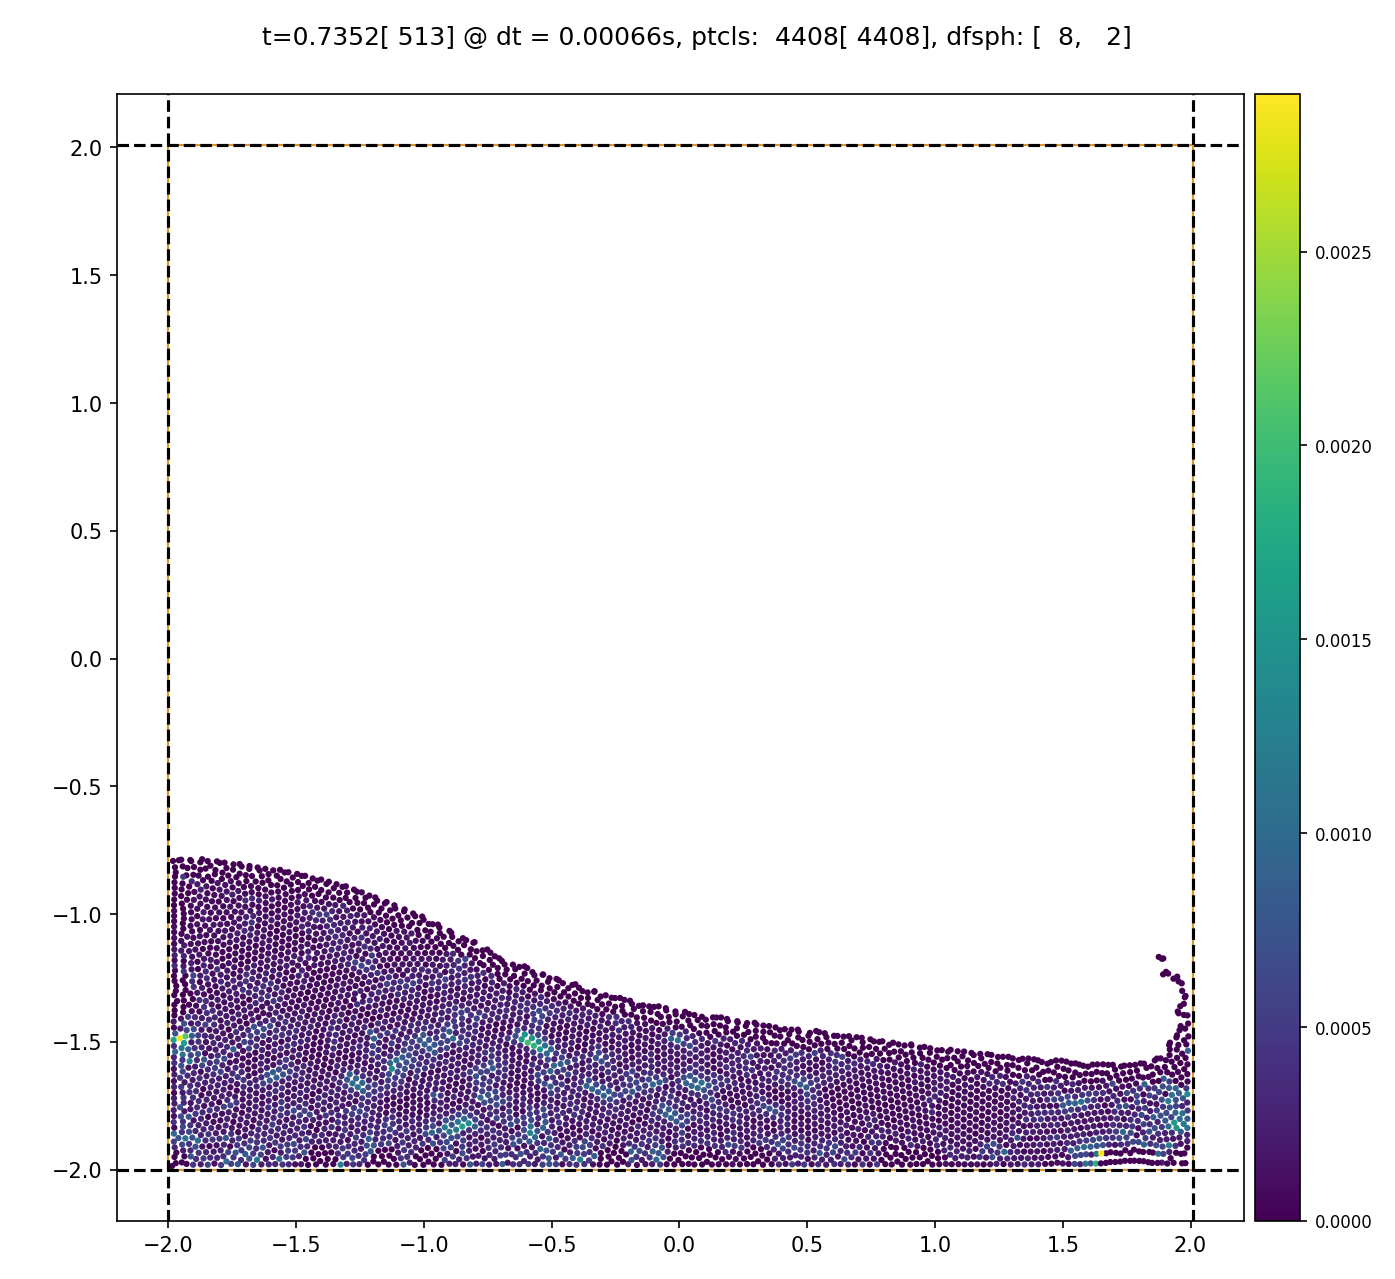

In [700]:

# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)
# sphSimulation.initializeSimulation()
# sphSimulation.timestep()

fig, axis = sphSimulation.createPlot(plotScale = 2)

state = sphSimulation.simulationState

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()


sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# quiverData = state['lambdaGrad'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)


fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [701]:
for i in range(512):
    sphSimulation.timestep()

    
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
#     data = state['fluidDensity'].detach().cpu().numpy()

    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
    if 'densityErrors' in state and not 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
    if 'divergenceErrors' in state and not 'densityErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
    if 'densityErrors' in state and 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


    if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
        raise Exception('Simulation borked')